In [1]:
import numpy as np
import torch
import torch.optim as optim
import torch.nn as nn
from torch.autograd import grad

import matplotlib
matplotlib.rcParams['text.usetex'] = True
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec


import time
# import copy

from os import path
import pickle
from scipy.integrate import simps
  
import warnings
warnings.filterwarnings('ignore')

dtype = torch.double    
torch.set_default_tensor_type('torch.DoubleTensor')

lineW = 3
lineBoxW=2

font = {'size'   : 18}
matplotlib.rc('font', **font)
plt.rcParams['font.size']=28
plt.rcParams['lines.markersize'] = 12
plt.rcParams.update({"text.usetex": True})
# plt. close('all')


# Check to see if gpu is available. If it is, use it else use the cpu
if torch.cuda.is_available():
    # device = torch.device('cuda')
    device = torch.device("cuda:0") 
    print('Using ', device, ': ', torch.cuda.get_device_name())   
    # torch.set_default_tensor_type(torch.cuda.FloatTensor)  
    torch.set_default_tensor_type(torch.cuda.DoubleTensor)  
else:
    device = torch.device('cpu')
    torch.set_default_tensor_type('torch.DoubleTensor')
    print('No GPU found, using cpu')



Using  cuda:0 :  NVIDIA GeForce RTX 3060 Ti


In [2]:
def set_params():
    params = dict()
    
    boundaries = 18
    params['xL']= -boundaries; params['xR']= boundaries
    params['yL']= -boundaries; params['yR']= boundaries
    params['zL']= -boundaries; params['zR']= boundaries
    params['BCcutoff'] = 17.5


    params['RxL'] = 0.2; params['RxR']= 4
    params['Ry']= 0 ; params['Rz']= 0  
    
    params['cutOff']= 0.005
    params['lossPath'] = "data/loss_ionH.pkl" ; 
    params['EnergyPath']= "data/energy_ionH.pkl" ; 
    params['saveModelPath']="models/ionHsym.pt"
    params['loadModelPath']="models/ionHsym.pt"
    params['EnrR_path'] = "data/energy_R_ion.pkl"

       
    params['sc_step'] = 3000; params['sc_decay']=.7 ## WAS 3000
    params['sc_sampling']= 1

    params['n_train'] = 100000; params['n_test'] = 80
    params['epochs'] = int(5e3); #2e3        
    params['lr'] = 8e-3; 

    params['inversion_symmetry'] = 1  
    
    return params

In [3]:
def  exactE():
    # Taken by H. Wind, J. Chem. Phys. 42, 2371 (1965); https://doi.org/10.1063/1.1696302
    R_exact = np.round(np.arange(0.2, 4.1, .1),2)  
    e_exact  = np.zeros([len(R_exact),1])
    e_exact = [-1.8008, -1.6715, -1.5545, 
               -1.4518, -1.3623, -1.2843, -1.2159, -1.1558,
               -1.1026, -1.0554, -1.0132,  -0.9754, -0.9415,
               -0.9109, -0.8832, -0.8582, -0.8355, -0.8149,
               -0.7961, -0.7790, -0.7634, -0.7492, -0.7363,
               -0.7244, -0.7136, -0.7037, -0.6946, -0.6863,
               -0.6786, -0.6716, -0.6651, -0.6591, -0.6536,
               -0.6485, -0.6437, -0.6392, -0.6351,-0.6312,
               -0.6276] #, -0.62, -0.62, -0.62, -0.615,
               # -0.61, -0.61, -0.61, -0.605,-0.60,
               # -0.60]
    return R_exact, e_exact

In [4]:
##################### ACTIVATION FUNCTIONS    
class toR(torch.nn.Module):
    @staticmethod
    def forward(input):
        r2=input[:,0].pow(2)+input[:,1].pow(2)+input[:,2].pow(2)
        r = torch.sqrt(r2); r=r.reshape(-1,1)
        return r

class atomicAct_s(torch.nn.Module):
    @staticmethod
    def forward(input):
        return  torch.exp(-input) 


    ## Differential Operators using autograd: 
    
def dfx(x,f):
    return grad([f], [x], grad_outputs=torch.ones(x.shape, dtype=dtype), create_graph=True)[0]

def d2fx(x,f):
    return grad(dfx(x,f), [x], grad_outputs=torch.ones(x.shape, dtype=dtype), create_graph=True)[0]

def lapl(x,y,z,f):
    # Laplacian operator
    f_xx, f_yy, f_zz = d2fx(x,f), d2fx(y,f), d2fx(z,f)
    return f_xx + f_yy + f_zz

    ## Misc physical functions

def radial(x,y,z,R,params):
    # Returns the radial part from cartesian coordinates
    Rx = R
    Ry= params['Ry']; Rz= params['Rz']
    r1 =  torch.sqrt((x-Rx).pow(2)+(y-Ry).pow(2)+(z-Rz).pow(2))
    r2 =  torch.sqrt((x+Rx).pow(2)+(y+Ry).pow(2)+(z+Rz).pow(2))
    return r1, r2

def V(x,y,z, R, params):
    ## Potential energy function
    r1,r2 = radial(x,y,z,R, params)
    potential = -1/r1 -1/r2
    return potential
    
def hamiltonian(x,y,z,R,psi,params):
    laplacian = lapl(x,y,z,psi)        
    return  -0.5*laplacian + V(x,y,z,R,params)*psi
        

    ## Misc helper functions 

def sampling(params, n_points, linearSampling=False):
# Sampling from a 4d space: 3d variable (x,y,z) and 1d parameter (R) space
    xR=params['xR']; xL = params['xL']; yR = params['yR'];
    yL=params['yL']; zR = params['zR']; zL = params['zL']; 
    cutOff=params['cutOff']
    
    if linearSampling==True:
        x = torch.linspace(xL,xR,n_points, requires_grad=False)
        y = torch.linspace(yL,yR,n_points, requires_grad=False)
        z = torch.linspace(zL,zR,n_points, requires_grad=False)
        R = torch.linspace(params['RxL'],params['RxR'],n_points, requires_grad=False)
    else: 
        x = (xL - xR) * torch.rand(n_points,1) + xR
        y = (yL - yR) * torch.rand(n_points,1) + yR
        z = (zL - zR) * torch.rand(n_points,1) + zR
        R = (params['RxL'] - params['RxR'])* torch.rand(n_points,1) + params['RxR']
        
    r1,r2 = radial(x,y,z,R,params)
    x[r1<cutOff] = cutOff
    x[r2<cutOff] = cutOff
    x,y,z = x.reshape(-1,1), y.reshape(-1,1), z.reshape(-1,1); R=R.reshape(-1,1)        
    x.requires_grad=True; y.requires_grad=True; z.requires_grad=True; R.requires_grad=True     
    return x,y,z, R

def saveLoss(params, lossDictionary):
    with open(params['lossPath'], 'wb') as f:
        pickle.dump(lossDictionary, f)
        
def returnGate():
    modelTest = NN_ion(params);     modelTest.loadModel(params)   
    R = torch.linspace(params['RxL'],params['RxR'],params['n_train'], requires_grad=False)
    R=R.reshape(-1,1)
    R.requires_grad=True
    f = modelTest.netDecayL(R)
    f = modelTest.sig(f)
    f = modelTest.netDecay(f) 
    return R.cpu().detach().numpy(), f.cpu().detach().numpy()


def integra3d(x,y,z, f):   
    # 3d integration using Simpson method of scipy
    f = f.detach().numpy()
    x = x.detach().numpy()
    y = y.detach().numpy()
    z = z.detach().numpy()
    I = simps( [simps( [simps(fx, x) for fx in fy], y) for fy in f ]  ,z)
    return I


def plotLoss(params,  saveFig=True):
    with open(params['lossPath'], 'rb') as f:
        loaded_dict = pickle.load(f)

    plt.figure(figsize=[19,8])
    plt.subplot(1,2,1)
    plt.plot(loaded_dict['Ltot'],label='total',linewidth=lineW*2)
    plt.plot(loaded_dict['Lpde'],label='pde',linewidth=lineW)    
    plt.plot(loaded_dict['Lbc'] ,label='bc',linewidth=lineW)
    plt.ylabel('Loss'); plt.xlabel('epochs')
    plt.axvline(params['epochs'], c='r', linestyle='--', linewidth=lineW*1.5, alpha=0.7)
    plt.yscale('log')
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(loaded_dict['Energy'],'-k',linewidth=lineW)
    plt.ylabel('Energy'); plt.xlabel('epochs')
    plt.axvline(params['epochs'], c='r', linestyle='--', linewidth=lineW*1.5, alpha=0.7)
    plt.tight_layout()
    
    if saveFig==True:
        plt.savefig('figures/loss_figure.jpg', format='jpg')


## Network Architecture

In [5]:
##----------------------- Network Class ---------------------
# Neural Network Architecture 
class NN_ion(nn.Module):
    def __init__(self, params, dense_neurons=16, dense_neurons_E=32, netDecay_neurons=10): 
        super(NN_ion,self).__init__()

        self.sig =  nn.Sigmoid()          
        self.toR= toR()
        self.actAO_s = atomicAct_s()  
        self.Lin_H1   = torch.nn.Linear(2, dense_neurons) 
        self.Lin_H2   = torch.nn.Linear(dense_neurons, dense_neurons, bias=True) 
        
        self.Lin_out = torch.nn.Linear(dense_neurons, 1)                
        
        self.Lin_E1   = torch.nn.Linear(1, dense_neurons_E) 
        self.Lin_E2   = torch.nn.Linear(dense_neurons_E, dense_neurons_E) 

        self.Lin_Eout = torch.nn.Linear(dense_neurons_E, 1)                
        nn.init.constant_(self.Lin_Eout.bias[0], -1 ) 

        self.Ry = params['Ry'];    self.Rz = params['Rz']
        self.P =  params['inversion_symmetry']
        self.netDecayL = torch.nn.Linear(1, netDecay_neurons, bias=True)  
        self.netDecay = torch.nn.Linear(netDecay_neurons, 1, bias=True)  


    def forward(self,x,y,z,R):        
## ENERGY PARAMETER
        e = self.Lin_E1(R); e = self.sig(e)
        e = self.Lin_E2(e); e = self.sig(e)
        E = self.Lin_Eout(e)
        
## ATOMIC Layer: Radial part and physics-based activation
        fi_r1,  fi_r2  = self.atomicUnit(x,y,z, R)        
        fi_r1m, fi_r2m = self.atomicUnit(-x,y,z,R)        
## LCAO SOLUTION
        N_LCAO = self.lcao_solution(fi_r1, fi_r2)
## NONLINEAR HIDDEN LAYERS        
        B  = self.base(fi_r1,fi_r2) + self.P*self.base(fi_r1m,fi_r2m)
        NN = self.Lin_out(B)
    
        f = self.netDecayL(R)
        f = self.sig(f)
        f = self.netDecay(f) 
        NN=NN*f

        Nout = NN + N_LCAO        
        return Nout, E

    def atomicUnit(self, x,y,z, R):
        x1 = x - R; 
        y1 = y- self.Ry; z1 = z - self.Rz     # Cartesian Translation & Scaling:    
        rVec1=torch.cat((x1,y1,z1),1)
        r1 = self.toR(rVec1) 
        fi_r1 = self.actAO_s(r1);  # s- ATOMIC ORBITAL ACTIVATION
# -- 
        x2 = x + R; 
        y2 = y + self.Ry; z2 = z + self.Rz        
        rVec2=torch.cat((x2,y2,z2),1)
        r2 = self.toR(rVec2);         fi_r2 = self.actAO_s(r2);  
        return fi_r1, fi_r2

    def lcao_solution(self,fi_r1, fi_r2,  ):
## LCAO solution: Linear combination
        N_LCAO= (fi_r1 + self.P* fi_r2)        
        return N_LCAO
    
    def base(self,fi_r1,fi_r2):
## NONLINEAR HIDDEN LAYERS; Black box
        fi_r = torch.cat((fi_r1, fi_r2),1)    
        fi_r = self.Lin_H1(fi_r);         fi_r = self.sig(fi_r) 
        fi_r = self.Lin_H2(fi_r);         fi_r = self.sig(fi_r) 
        # fi_r = self.Lin_H3(fi_r);         fi_r = self.sig(fi_r) 
        return fi_r
        
    def freezeBase(self):
    #         for p in self.parameters():
#             p.requires_grad=False
        self.Lin_H1.weight.requires_grad=False
        self.Lin_H1.bias.requires_grad=False
        self.Lin_H2.weight.requires_grad=False
        self.Lin_H2.bias.requires_grad=False    
        self.Lin_out.weight.requires_grad=False
        self.Lin_out.bias.requires_grad=False
        
    def freezeDecayUnit(self):
        self.netDecayL.weight.requires_grad=False
        self.netDecayL.bias.requires_grad=False
        self.netDecay.weight.requires_grad=False
        self.netDecay.bias.requires_grad=False
        
    def parametricPsi(self, x,y,z,R):
        N, E = self.forward(x,y,z,R) 
        return  N, E

   
    def loadModel(self,params):
        checkpoint = torch.load(params['loadModelPath'])
        self.load_state_dict(checkpoint['model_state_dict'])
        self.eval(); 


    def saveModel(self,params, optimizer):
        torch.save({
            # 'epoch': epoch,
            'model_state_dict': self.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            # 'loss': loss
        },  params['saveModelPath'])   
    
    
    def LossFunctions(self, x,y,z,R,params, bIndex1, bIndex2):
        lam_bc, lam_pde = 1 , 1    #lam_tr = 1e-9
        psi, E = self.parametricPsi(x,y,z,R)
#--# PDE       
        res = hamiltonian(x,y,z,R,psi,params) - E*psi                
        LossPDE = (res.pow(2)).mean() * lam_pde
        Ltot= LossPDE         
#--# BC
        Lbc =  lam_bc *( (psi[bIndex1].pow(2)).mean() 
               + (psi[bIndex2].pow(2)).mean() )

        Ltot= LossPDE + Lbc
# 
        #--# Trivial
        # Ltriv = 1/(psi.pow(2)).mean()* lam_tr ;    Ltot = Ltot + Ltriv 
        return Ltot, LossPDE, Lbc, E

## Training: Helper Function

In [6]:
def train(params, loadWeights=False, freezeUnits=False):
    lr = params['lr']; 
    model = NN_ion(params);     # modelBest=copy.deepcopy(model)

    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=0)
    print('train with Adam')   
    # optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.5)
    # print('train with SGD')

    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=params['sc_step'], gamma=params['sc_decay'])    
    Llim =  10 ; optEpoch=0    

    epochs=params['epochs'] # For Adam 
    total_epochs = epochs
    # total_epochs = params['epochs_LB'] + epochs
    Ltot_h = np.zeros([total_epochs,1]); Lpde_h = np.zeros([total_epochs,1])
    Lbc_h= np.zeros([total_epochs,1]);   E_h = np.zeros([total_epochs,1]); 
    # Ltr_h = np.zeros([total_epochs,1]); Linv_h= np.zeros([total_epochs,1])
    
    ## LOADING pre-trained model if PATH file exists and loadWeights=True
    if path.exists(params['loadModelPath']) and loadWeights==True:
        print('loading model')
        model.loadModel(params) 

    if  freezeUnits==True:
        print('Freezeing Basis unit and Gate')
        model.freezeDecayUnit()
        model.freezeBase()

        
    TeP0 = time.time() # for counting the training time
        
    n_points = params['n_train'] # the training batch size
    x,y,z,R = sampling(params,n_points, linearSampling=False)
    
    r1,r2 = radial(x, y, z,R, params)
    bIndex1 = torch.where(r1 >= params['BCcutoff'])
    bIndex2 = torch.where(r2 >= params['BCcutoff'])
    
#####--------------------------------------------------------------------    
############### TRAINING LOOP ########################    
#####--------------------------------------------------------------------
    for tt in range(epochs):        
        optimizer.zero_grad()
        
        if tt % params['sc_sampling']==0 and tt < 0.9*epochs:
            x,y,z,R = sampling(params, n_points, linearSampling=False)            
            r1,r2 = radial(x, y, z,R, params)
            bIndex1 = torch.where(r1 >= params['BCcutoff']   )
            bIndex2 = torch.where(r2 >= params['BCcutoff']   )        
        
        Ltot, LossPDE, Lbc, E = model.LossFunctions(x,y,z,R,params, bIndex1, bIndex2)
        

        Ltot.backward(retain_graph=False); optimizer.step(); 
        # if  tt < 2001:
        #     scheduler.step()
        
        if (tt+1)%100 == 0:
            print(f'epoch {tt+1}/{epochs}')

# keep history           
        Ltot_h[tt] = Ltot.cpu().data.numpy();  Lpde_h[tt] = LossPDE.cpu().data.numpy()
        Lbc_h[tt]  =  Lbc.cpu().data.numpy();  E_h[tt]    = E[-1].cpu().data.numpy()
        # Ltr_h[tt]  = Ltriv.data.numpy();  
        
#    Keep the best model (lowest loss). Checking after 50% of the total epochs 
        if  tt > 0.5*epochs  and Ltot < Llim:
            Llim=Ltot
            model.saveModel(params, optimizer)
            optEpoch = tt
            
    print('Optimal epoch: ', optEpoch)

#####--------------------------------------------------------------------
##### END TRAINING
#####--------------------------------------------------------------------
    TePf = time.time();    runTime = TePf - TeP0        

    lossDictionary = {'Ltot':  Ltot_h,  'Lbc': Lbc_h, 'Lpde':Lpde_h, 'Energy': E_h }
    saveLoss(params, lossDictionary)

    print('Runtime (min): ', runTime/60)    
    print('last learning rate: ', scheduler.get_last_lr())
    # return E,R

## Training


In [7]:
params=set_params()

params['epochs'] = int(5e3);  nEpoch1 = params['epochs']
params['n_train'] = 100000 
params['lr'] = 8e-3;




In [8]:
#### ----- Training: Single model ---=---------
train(params, loadWeights=False);  


train with Adam
epoch 100/5000
epoch 200/5000
epoch 300/5000
epoch 400/5000
epoch 500/5000
epoch 600/5000
epoch 700/5000
epoch 800/5000
epoch 900/5000
epoch 1000/5000
epoch 1100/5000
epoch 1200/5000
epoch 1300/5000
epoch 1400/5000
epoch 1500/5000
epoch 1600/5000
epoch 1700/5000
epoch 1800/5000
epoch 1900/5000
epoch 2000/5000
epoch 2100/5000
epoch 2200/5000
epoch 2300/5000
epoch 2400/5000
epoch 2500/5000
epoch 2600/5000
epoch 2700/5000
epoch 2800/5000
epoch 2900/5000
epoch 3000/5000
epoch 3100/5000
epoch 3200/5000
epoch 3300/5000
epoch 3400/5000
epoch 3500/5000
epoch 3600/5000
epoch 3700/5000
epoch 3800/5000
epoch 3900/5000
epoch 4000/5000
epoch 4100/5000
epoch 4200/5000
epoch 4300/5000
epoch 4400/5000
epoch 4500/5000
epoch 4600/5000
epoch 4700/5000
epoch 4800/5000
epoch 4900/5000
epoch 5000/5000
Optimal epoch:  3116
Runtime (min):  11.575185398260752
last learning rate:  [0.008]


In [8]:
optEpoch = 4293

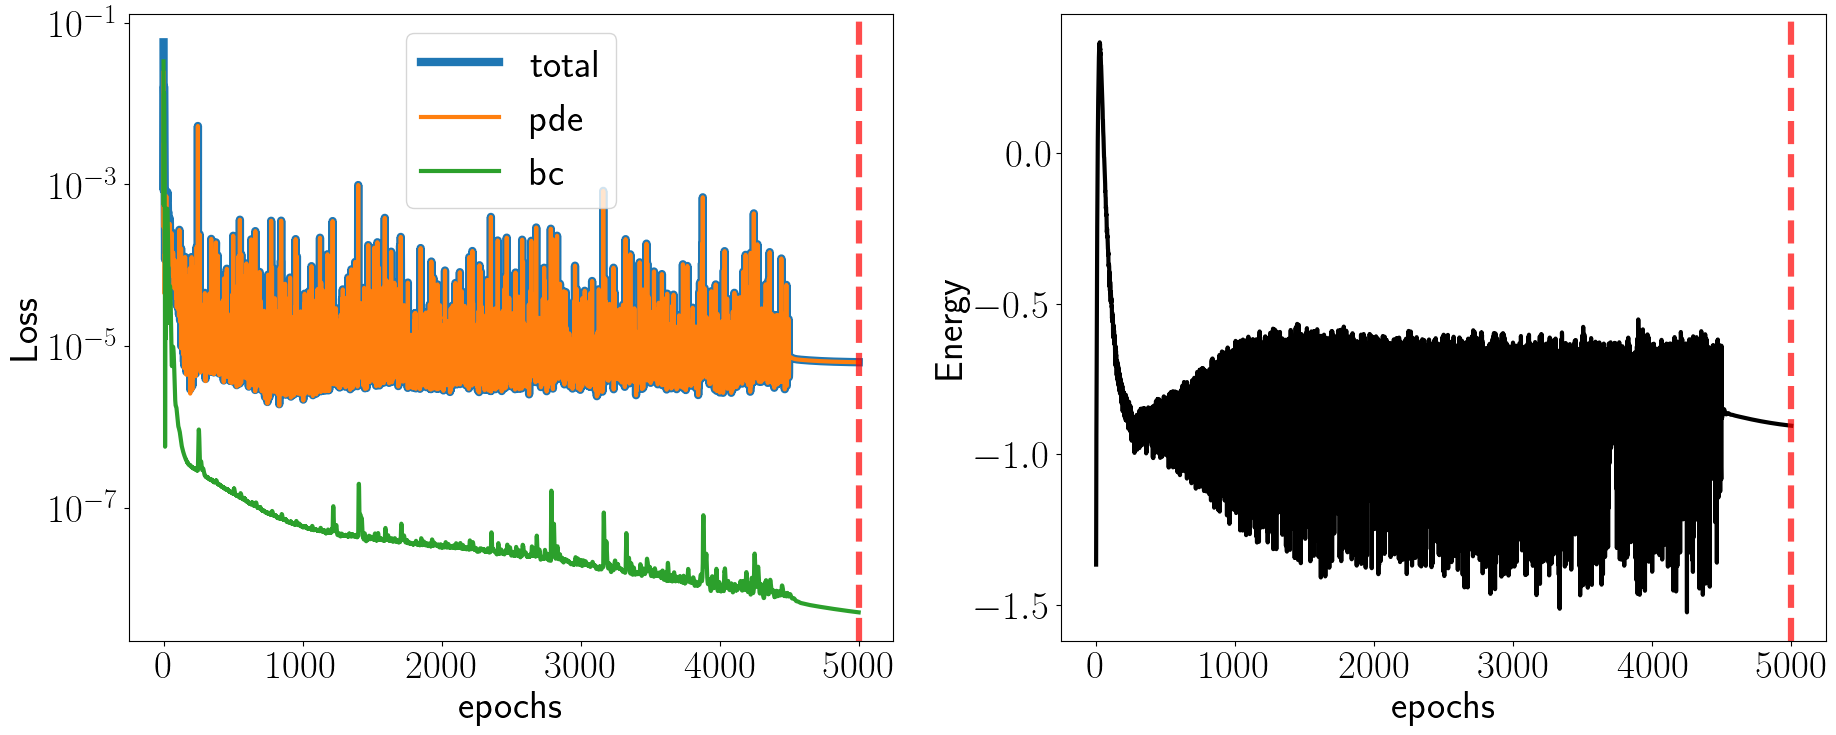

In [9]:
plotLoss(params, saveFig=False)

### GATE: Network-importance function

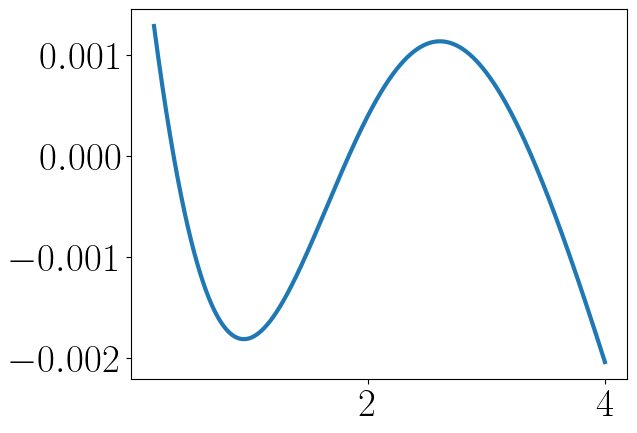

In [10]:
Rg, gate = returnGate()
plt.plot(Rg, gate, linewidth=lineW)


### Fine tuning

In [11]:
# params=set_params()
params['loadModelPath']="models/ionHsym.pt"
params['lossPath'] = "data/loss_ionH_fineTune.pkl" ; 
params['EnergyPath']= "data/energy_ionH_fineTune.pkl" ; 
params['saveModelPath']="models/ionHsym_fineTune.pt"


# params['sc_step'] = 10000; params['sc_decay']=.7
params['sc_sampling']= 1


params['epochs'] = int(2e3); nEpoch2 = params['epochs']
params['n_train'] = 100000 
params['lr'] = 5e-4;


In [12]:
train(params, loadWeights=True, freezeUnits=True); 

train with Adam
loading model
Freezeing Basis unit and Gate
epoch 100/2000
epoch 200/2000
epoch 300/2000
epoch 400/2000
epoch 500/2000
epoch 600/2000
epoch 700/2000
epoch 800/2000
epoch 900/2000
epoch 1000/2000
epoch 1100/2000
epoch 1200/2000
epoch 1300/2000
epoch 1400/2000
epoch 1500/2000
epoch 1600/2000
epoch 1700/2000
epoch 1800/2000
epoch 1900/2000
epoch 2000/2000
Optimal epoch:  1556
Runtime (min):  3.549221114317576
last learning rate:  [0.0005]


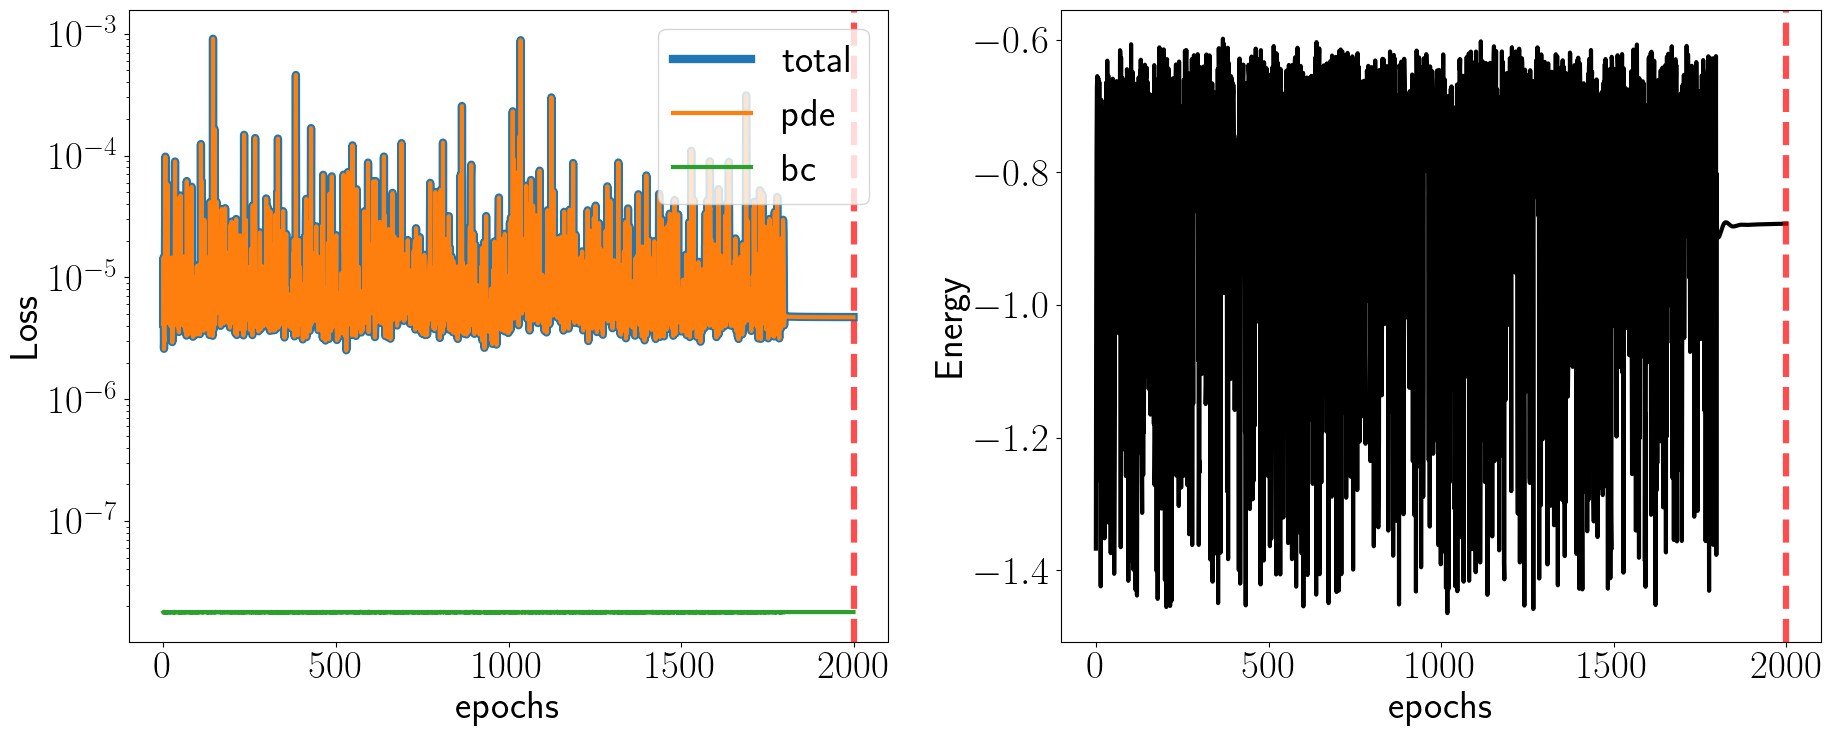

In [13]:
plotLoss(params, saveFig=False)

# ANALYSIS

In [14]:
# params['loadModelPath']="models/ionHsym_fineTune.pt"
# modelTest = NN_ion(params);     modelTest.loadModel(params)   
# _, E_ft = modelTest.parametricPsi(x, y, z, R);
# E_ft=E_ft.cpu().detach().numpy()

def energy_from_psi(Ri,param):
    print(params['loadModelPath'])
    modelTest = NN_ion(params);    modelTest.loadModel(params)   
    
    x,y,z, R   = sampling(params, params['n_test'], linearSampling=True)
    x=x.ravel(); y=y.ravel(); z=z.ravel() 

    xg, yg, zg= torch.meshgrid(x, y, z)
    xgg = xg.reshape(-1,1); ygg = yg.reshape(-1,1); zgg = zg.reshape(-1,1)

    Rt = Ri*torch.ones_like(xgg)

    psi_, E = modelTest.parametricPsi(xgg, ygg, zgg, Rt);
    psi = psi_.reshape(params['n_test'],params['n_test'],params['n_test'])    
    # # Energy from psi    
    h_psi = hamiltonian(xgg,ygg,zgg, Rt, psi_, params)

    x=x.cpu(); y=y.cpu(); z=z.cpu();     psi=psi.cpu();     h_psi=h_psi.cpu(); 

    h_psi = h_psi.reshape(params['n_test'],params['n_test'],params['n_test'])
    E_integral = integra3d(x,y,z, psi * h_psi) / integra3d(x,y,z, (psi).pow(2))

    E_net = E[-1].cpu().detach().numpy()      
    return E_integral, E_net


def energy_from_psi_LCAO(Ri,params):
    modelTest = NN_ion(params);    modelTest.loadModel(params)        
    x,y,z, R   = sampling(params, params['n_test'], linearSampling=True)
    x=x.ravel(); y=y.ravel(); z=z.ravel() 

    xg, yg, zg= torch.meshgrid(x, y, z)
    xgg = xg.reshape(-1,1); ygg = yg.reshape(-1,1); zgg = zg.reshape(-1,1)

    Rt = Ri*torch.ones_like(xgg)

    fi_r1, fi_r2 = modelTest.atomicUnit(xgg, ygg, zgg, Rt)  
    psi_ = modelTest.lcao_solution(fi_r1, fi_r2)
    psi = psi_.reshape(params['n_test'],params['n_test'],params['n_test'])    
    # # Energy from psi    
    h_psi = hamiltonian(xgg,ygg,zgg, Rt, psi_, params)

    x=x.cpu(); y=y.cpu(); z=z.cpu(); psi=psi.cpu();     h_psi=h_psi.cpu(); 
    h_psi = h_psi.reshape(params['n_test'],params['n_test'],params['n_test'])
    E_integral = integra3d(x,y,z, psi * h_psi) / integra3d(x,y,z, (psi).pow(2))
    return E_integral


def calculate_E_R(params):
    # modelTest = NN_ion(params);    modelTest.loadModel(params)        
    Rx_list_net = np.round(np.arange(params['RxL'], params['RxR']+.1, .1),2)  

    i=0
    E_int = np.zeros(len(Rx_list_net)); E_net = np.zeros(len(Rx_list_net)); rE  = np.zeros(len(Rx_list_net))
    E_int_lcao = np.zeros(len(Rx_list_net)); 

    for Ri in Rx_list_net:
        torch.cuda.empty_cache()
        E_int[i], E_net[i] = energy_from_psi(Ri,params)
        E_int_lcao[i]      = energy_from_psi_LCAO(Ri,params)
        rE[i]=Ri
        i = i+1

    energyDictionary = {'R':rE, 'E_int':  E_int,  'Elcao': E_int_lcao, 'E_net':  E_net}
    #save
    with open(params['EnrR_path'], 'wb') as f:
        pickle.dump(energyDictionary, f)        


def load_E_R(params):        
    with open(params['EnrR_path'], 'rb') as f:
        E_loaded_dict = pickle.load(f)
    
    E_int = E_loaded_dict["E_int"]
    E_lcao = E_loaded_dict["Elcao"]
    E_net = E_loaded_dict["E_net"]
    rE = E_loaded_dict["R"]
    return E_int, E_lcao, rE, E_net

### COMPUTE AND SAVE E(R)        

In [15]:
params['n_test']=50
params['loadModelPath']="models/ionHsym_fineTune.pt"
calculate_E_R(params)

## TO LOAD
E_int, E_lcao, rE, E_net = load_E_R(params)

models/ionHsym_fineTune.pt
models/ionHsym_fineTune.pt
models/ionHsym_fineTune.pt
models/ionHsym_fineTune.pt
models/ionHsym_fineTune.pt
models/ionHsym_fineTune.pt
models/ionHsym_fineTune.pt
models/ionHsym_fineTune.pt
models/ionHsym_fineTune.pt
models/ionHsym_fineTune.pt
models/ionHsym_fineTune.pt
models/ionHsym_fineTune.pt
models/ionHsym_fineTune.pt
models/ionHsym_fineTune.pt
models/ionHsym_fineTune.pt
models/ionHsym_fineTune.pt
models/ionHsym_fineTune.pt
models/ionHsym_fineTune.pt
models/ionHsym_fineTune.pt
models/ionHsym_fineTune.pt
models/ionHsym_fineTune.pt
models/ionHsym_fineTune.pt
models/ionHsym_fineTune.pt
models/ionHsym_fineTune.pt
models/ionHsym_fineTune.pt
models/ionHsym_fineTune.pt
models/ionHsym_fineTune.pt
models/ionHsym_fineTune.pt
models/ionHsym_fineTune.pt
models/ionHsym_fineTune.pt
models/ionHsym_fineTune.pt
models/ionHsym_fineTune.pt
models/ionHsym_fineTune.pt
models/ionHsym_fineTune.pt
models/ionHsym_fineTune.pt
models/ionHsym_fineTune.pt
models/ionHsym_fineTune.pt
m

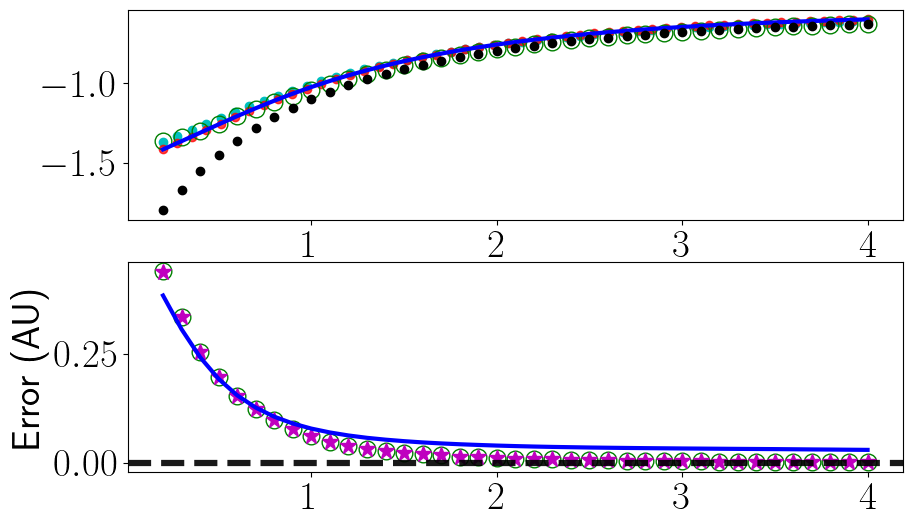

In [16]:
# ERROR 
fig = plt.figure(figsize=(10, 6))

marker_style_exact = dict(color='k', linestyle='none', marker='.', 
                      fillstyle='full',linewidth=lineW)
marker_style_int = dict(color='g', linestyle='none', marker='o', 
                      fillstyle='none', linewidth=lineW)
marker_style_net = dict(color='b', linestyle='-',linewidth=lineW)


x,y,z, R   = sampling(params, params['n_test'], linearSampling=True)
params['loadModelPath']="models/ionHsym.pt"
modelTest = NN_ion(params);     modelTest.loadModel(params)   
_, E_tr = modelTest.parametricPsi(x, y, z, R);
E_tr=E_tr.cpu().detach().numpy()

params['loadModelPath']="models/ionHsym_fineTune.pt"
modelTest = NN_ion(params);     modelTest.loadModel(params)   
_, E_ft = modelTest.parametricPsi(x, y, z, R);
E_ft=E_ft.cpu().detach().numpy()



E_int, E_int_lcao, rE, E_net  = load_E_R(params)
Rexact, e_exact = exactE() 




plt.subplot(2,1,1)
plt.plot(R.cpu().detach().numpy(), E_tr, '.c', label='training', linewidth=lineW)
plt.plot(R.cpu().detach().numpy(), E_ft, '.r', label='fine tuning', linewidth=lineW,alpha=0.75)

plt.plot(rE,E_int,**marker_style_int)
# plt.plot(rE,E_int_lcao,'*m')
plt.plot(rE,E_net,'b',  **marker_style_net)
plt.plot(rE,e_exact,'b',  **marker_style_exact)



plt.subplot(2,1,2)
df_net, df_int, df_lcao = E_net-e_exact, E_int-e_exact, E_int_lcao-e_exact
## Compute the Relative error
# df_net = -df_net/e_exact*100; df_int = -df_int/e_exact*100; df_lcao =-df_lcao/e_exact*100

plt.plot(rE,df_int,**marker_style_int)
plt.plot(rE,df_lcao,'*m')
plt.plot(rE,df_net,'b',  **marker_style_net)
plt.ylabel('Error (AU)');  
# plt.ylim(-0.02,0.06); plt.yticks([0,0.025,0.05])


plt.axhline(0, c='k', linestyle='--', linewidth=lineW*1.5, alpha=0.9)




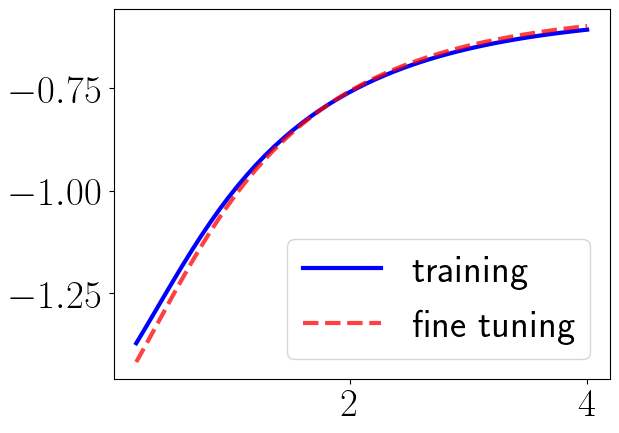

In [17]:
x,y,z, R   = sampling(params, params['n_test'], linearSampling=True)
# Rx_list_net = np.round(np.arange(params['RxL'], params['RxR']+.1, .1),2)  


params['loadModelPath']="models/ionHsym.pt"
modelTest = NN_ion(params);     modelTest.loadModel(params)   
_, E_tr = modelTest.parametricPsi(x, y, z, R);
E_tr=E_tr.cpu().detach().numpy()

params['loadModelPath']="models/ionHsym_fineTune.pt"
modelTest = NN_ion(params);     modelTest.loadModel(params)   
_, E_ft = modelTest.parametricPsi(x, y, z, R);
E_ft=E_ft.cpu().detach().numpy()


plt.plot(R.cpu().detach().numpy(), E_tr, '-b', label='training', linewidth=lineW)
plt.plot(R.cpu().detach().numpy(), E_ft, '--r', label='fine tuning', linewidth=lineW,alpha=0.75)
plt.legend()

# Make Final Figures

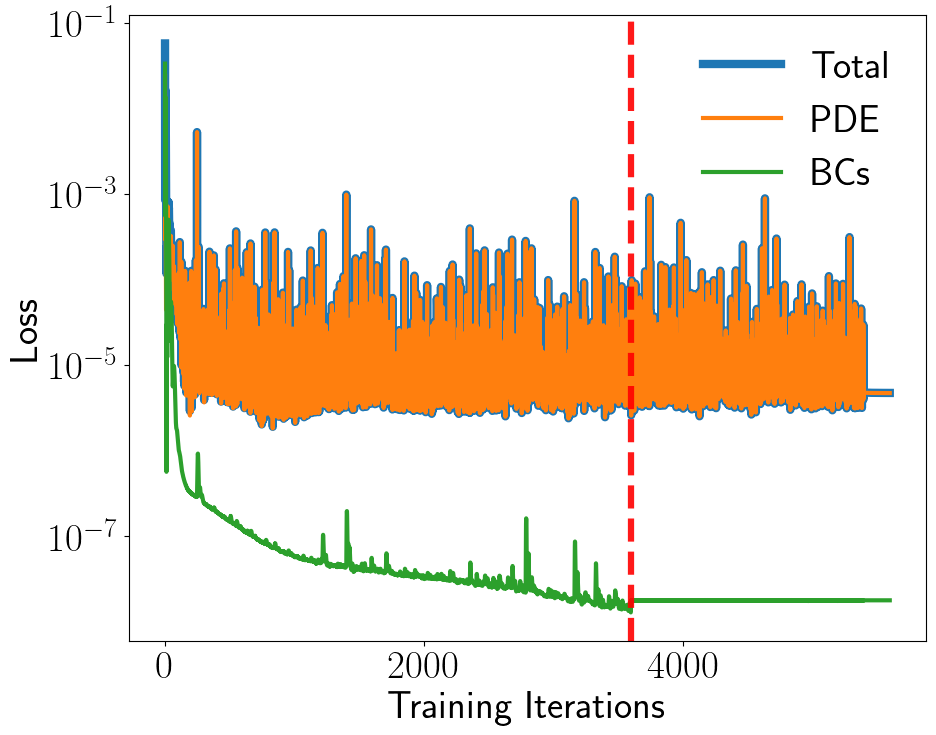

In [18]:
# plt.figure(figsize=[16,8])
plt.figure(figsize=[10,8])



params['lossPath'] = "data/loss_ionH.pkl" ; 
with open(params['lossPath'], 'rb') as f:
    loaded_dict = pickle.load(f)


params['lossPath'] = "data/loss_ionH_fineTune.pkl" ; 
with open(params['lossPath'], 'rb') as f:
    loaded_dict_FT = pickle.load(f)


optEpoch=nEpoch1
optEpoch = 3598
# optEpoch = 5000

lopt = loaded_dict['Ltot']; lopt = lopt[0:optEpoch]; loaded_dict['Ltot'] = lopt
lopt = loaded_dict['Lpde']; lopt = lopt[0:optEpoch]; loaded_dict['Lpde'] = lopt
lopt = loaded_dict['Lbc'];  lopt = lopt[0:optEpoch]; loaded_dict['Lbc'] = lopt


Ltot = np.concatenate((loaded_dict['Ltot'], loaded_dict_FT['Ltot']), axis=None)
Lpde = np.concatenate((loaded_dict['Lpde'], loaded_dict_FT['Lpde']), axis=None)
Lbc  = np.concatenate((loaded_dict['Lbc'], loaded_dict_FT['Lbc']), axis=None)   
    
    
plt.plot(Ltot,label='Total',linewidth=lineW*2)
plt.plot(Lpde,label='PDE',linewidth=lineW, alpha=1)    
plt.plot(Lbc ,label='BCs', linewidth=lineW, alpha=1)

plt.ylabel('Loss'); plt.xlabel('Training Iterations')
plt.axvline(optEpoch, c='r', linestyle='--', linewidth=lineW*1.5, alpha=0.9)
# plt.axvline(nEpoch1*0.9, c='k', linestyle='--', linewidth=lineW*1.5, alpha=0.9)
# plt.axvline(nEpoch1, c='r', linestyle='--', linewidth=lineW*1.5, alpha=0.9)
# plt.axvline(nEpoch1+nEpoch2*0.9, c='k', linestyle='--', linewidth=lineW*1.5, alpha=0.9)

plt.yscale('log')
plt.legend(frameon=False)


plt.tight_layout()
    
plt.savefig('loss_figure.pdf', format='pdf')




In [19]:
def psi3d(Ri, detachAll=True):
    modelTest = NN_ion(params);     modelTest.loadModel(params)   
    modelTest = modelTest.cpu()

    x,y,z, Rt  = sampling(params, params['n_test'], linearSampling=True); 
    x=x.cpu(); y=y.cpu(); z=z.cpu(); 
    x=x.ravel(); y=y.ravel(); z=z.ravel() ; 
    xg, yg, zg= torch.meshgrid(x, y, z)
    xgg = xg.reshape(-1,1); ygg = yg.reshape(-1,1); zgg = zg.reshape(-1,1)
    Rt = Ri*torch.ones_like(xgg)

    # NEURAL PSI
    psi_, E = modelTest.parametricPsi(xgg, ygg, zgg, Rt);
    psi = psi_.reshape(params['n_test'],params['n_test'],params['n_test'])
    # LCAO
    fi_r1, fi_r2 = modelTest.atomicUnit( xgg, ygg, zgg, Rt)  
    psi_L_  = modelTest.lcao_solution(fi_r1, fi_r2)
    psi_L = psi_L_.reshape(params['n_test'],params['n_test'],params['n_test'])
    if detachAll:
        x,y,z = x.detach().numpy(),y.detach().numpy(),z.detach().numpy(), 
        psi, psi_L= psi.detach().numpy(), psi_L.detach().numpy()
    return x,y,z,psi,psi_L


def psiX(Ri):
    x,y,z, psi, psi_L = psi3d(Ri)
    cN = int(params['n_test']/2);
    ps2 = (psi[:,:,cN]);     psiCut = ps2[:,cN].reshape(-1,1)
    ps2_L = (psi_L[:,:,cN]); ps2_LCut = (ps2_L[:,cN]).reshape(-1,1)
    return x, psiCut, ps2_LCut
    

def psi3d_norm(Ri,densePoints, dense_sampling=False,  detachAll=True):
    modelTest = NN_ion(params);     modelTest.loadModel(params)   
    modelTest = modelTest.cpu()

    x,y,z, Rt  = sampling(params, params['n_test'], linearSampling=True); 
    x=x.cpu(); y=y.cpu(); z=z.cpu(); 
    x=x.ravel(); y=y.ravel(); z=z.ravel() ; 
    xg, yg, zg= torch.meshgrid(x, y, z)
    xgg = xg.reshape(-1,1); ygg = yg.reshape(-1,1); zgg = zg.reshape(-1,1)
    Rt = Ri*torch.ones_like(xgg)

    # NEURAL PSI
    psi_, E = modelTest.parametricPsi(xgg, ygg, zgg, Rt);
    psi = psi_.reshape(params['n_test'],params['n_test'],params['n_test'])
    # LCAO
    fi_r1, fi_r2 = modelTest.atomicUnit( xgg, ygg, zgg, Rt)  
    psi_L_  = modelTest.lcao_solution(fi_r1, fi_r2)
    psi_L = psi_L_.reshape(params['n_test'],params['n_test'],params['n_test'])

    
    Npsi   = 1/np.sqrt(integra3d(x,y,z, (psi).pow(2)))
    Npsi_L = 1/np.sqrt(integra3d(x,y,z, (psi_L).pow(2)))    
    
    
    if dense_sampling:
        # nTest_ = params['n_test']
        params['n_test'] = densePoints
        x,y,z, Rt  = sampling(params, params['n_test'], linearSampling=True); 
        x=x.cpu(); y=y.cpu(); z=z.cpu(); 
        x=x.ravel(); y=y.ravel(); z=z.ravel() ; 
        xg, yg, zg= torch.meshgrid(x, y, z)
        xgg = xg.reshape(-1,1); ygg = yg.reshape(-1,1); zgg = zg.reshape(-1,1)
        Rt = Ri*torch.ones_like(xgg)

        # NEURAL PSI
        psi_, E = modelTest.parametricPsi(xgg, ygg, zgg, Rt);
        psi = psi_.reshape(params['n_test'],params['n_test'],params['n_test'])
        # LCAO
        fi_r1, fi_r2 = modelTest.atomicUnit( xgg, ygg, zgg, Rt)  
        psi_L_  = modelTest.lcao_solution(fi_r1, fi_r2)
        psi_L = psi_L_.reshape(params['n_test'],params['n_test'],params['n_test'])
    
    psi=psi*Npsi 
    psi_L = psi_L * Npsi_L
    
    if detachAll:
        x,y,z = x.detach().numpy(),y.detach().numpy(),z.detach().numpy(), 
        psi, psi_L= psi.detach().numpy(), psi_L.detach().numpy()
    return x,y,z,psi,psi_L




def psiX_norm(Ri,dense_sampling=False, densePoints=200):
    x,y,z, psi, psi_L = psi3d_norm(Ri,densePoints,dense_sampling)
    cN = int(params['n_test']/2);
    ps2 = (psi[:,:,cN]);     psiCut = ps2[:,cN].reshape(-1,1)
    ps2_L = (psi_L[:,:,cN]); ps2_LCut = (ps2_L[:,cN]).reshape(-1,1)
    return x, psiCut, ps2_LCut




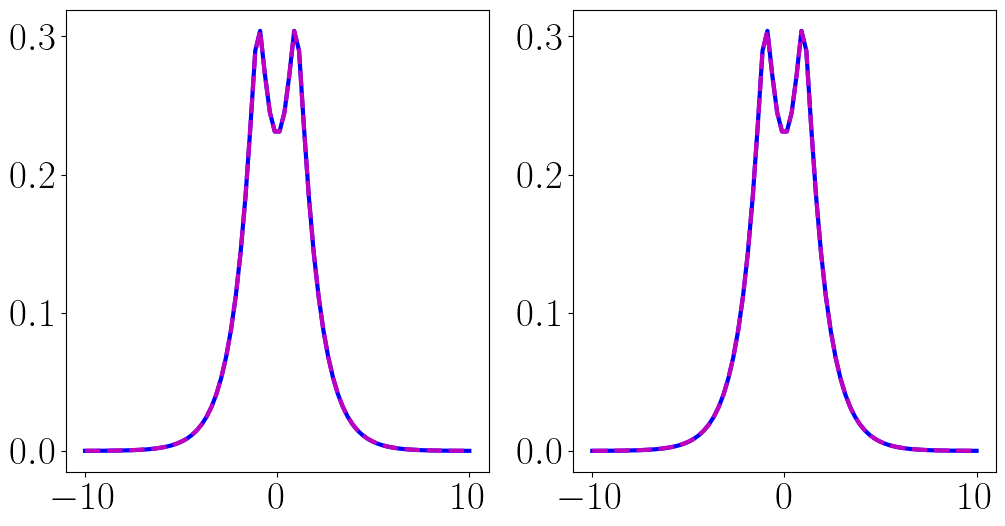

In [20]:
params['n_test'] = 80

boundaries = 10
params['xL']= -boundaries; params['xR']= boundaries
params['yL']= -boundaries; params['yR']= boundaries
params['zL']= -boundaries; params['zR']= boundaries


fig = plt.figure(figsize=(12, 6))
Ri = 1

plt.subplot(1,2,1)
x, p1, pL1 = psiX_norm(Ri,dense_sampling=True,densePoints=80)
plt.plot(x,p1,'b',linewidth=lineW, label='Neural $\psi$')
plt.plot(x,pL1,'--m',linewidth=lineW, label='LCAO');

plt.subplot(1,2,2)
x, p1, pL1 = psiX_norm(Ri,dense_sampling=False)
plt.plot(x,p1,'b',linewidth=lineW, label='Neural $\psi$')
plt.plot(x,pL1,'--m',linewidth=lineW, label='LCAO');

In [21]:
boundaries = 10
params['xL']= -boundaries; params['xR']= boundaries
params['yL']= -boundaries; params['yR']= boundaries
params['zL']= -boundaries; params['zR']= boundaries


densePoints= 50 #250 

Ri = 1; params['n_test'] = 80
x, p1, pL1 = psiX_norm(Ri, dense_sampling=True,densePoints=densePoints)

Ri = 2; params['n_test'] = 80
x, p2, pL2 = psiX_norm(Ri, dense_sampling=True,densePoints=densePoints)

Ri = 3; params['n_test'] = 80
x, p3, pL3 = psiX_norm(Ri, dense_sampling=True,densePoints=densePoints)

Ri = 4; params['n_test'] = 80
x, p4, pL4 = psiX_norm(Ri, dense_sampling=True,densePoints=densePoints)


params['n_test'] = 100


# Figure 2: Wavefunctions

In [22]:

marker_style_exact = dict(color='k', linestyle='none', marker='.', 
                      fillstyle='full',linewidth=lineW)

marker_style_int = dict(color='g', linestyle='none', marker='o', 
                      fillstyle='none', linewidth=lineW)

marker_style_net = dict(color='b', linestyle='-',linewidth=lineW)



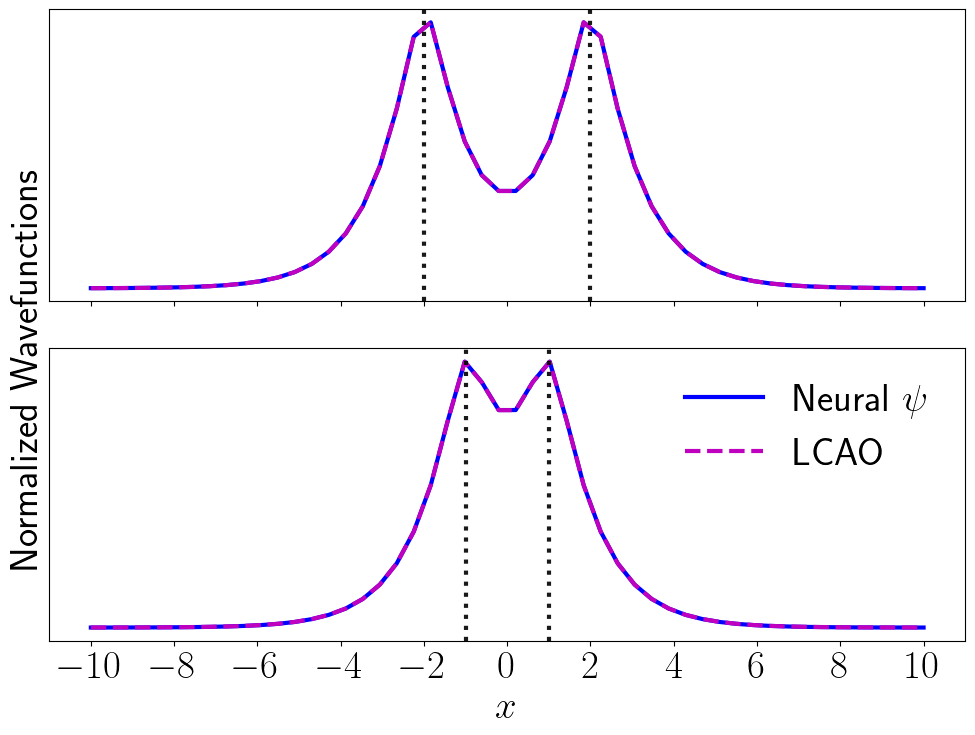

In [23]:
# params['loadModelPath']="models/ionHsym.pt"
params['loadModelPath']="models/ionHsym_fineTune.pt"


modelTest = NN_ion(params);     modelTest.loadModel(params)   
E_int, E_int_lcao, rE, E_net  = load_E_R(params)
Rexact, e_exact = exactE() 


Rtrain_L = params['RxL']; Rtrain_R = params['RxR']; 


xt,yt,zt, Rt1  = sampling(params, params['n_test'], linearSampling=True)
_, Enet_FT = modelTest.parametricPsi(xt, yt, zt, Rt1);
rr = Rt1.cpu().detach().numpy()
ee1 = Enet_FT.cpu().detach().numpy()


### FIGURE 
fig = plt.figure(figsize=(10, 8))



## WAVEFUNCTIONS
axP = plt.subplot2grid( (1,2), (0,0), colspan=2, rowspan=2); plt.tick_params('x', labelbottom=False)

# ##
plt.subplot2grid( (4,4), (2,2), colspan=2, rowspan=1,  sharex=axP)
ax=plt.subplot(2,1,1)
Ri=2
plt.tick_params('x', labelbottom=False)
plt.plot(x,p2,'b',linewidth=lineW)
plt.plot(x,pL2,'--m',linewidth=lineW)
plt.axvline(-Ri,  c='k', linestyle=':', linewidth=lineW*1, alpha=0.9)
plt.axvline(Ri,  c='k', linestyle=':', linewidth=lineW*1, alpha=0.9)
plt.yticks([]);  plt.xticks([])

##
plt.subplot(2,1,2,   sharex=ax)
Ri=1
# plt.subplot2grid( (4,4), (3,2), colspan=2, rowspan=1,  sharex=axP)
plt.plot(x,p1,'b',linewidth=lineW, label='Neural $\psi$')
plt.plot(x,pL1,'--m',linewidth=lineW, label='LCAO')
plt.axvline(-Ri,  c='k', linestyle=':', linewidth=lineW*1, alpha=0.9)
plt.axvline(Ri,  c='k', linestyle=':', linewidth=lineW*1, alpha=0.9)

fig.text(0.02, 0.5, 'Normalized Wavefunctions', ha='center', va='center', rotation='vertical')

plt.legend(frameon=False)
plt.xticks(np.arange(-10,12,2)); plt.xlabel("$x$"); plt.yticks([])

plt.tight_layout()



# plt.savefig('fig3.pdf', format='pdf')



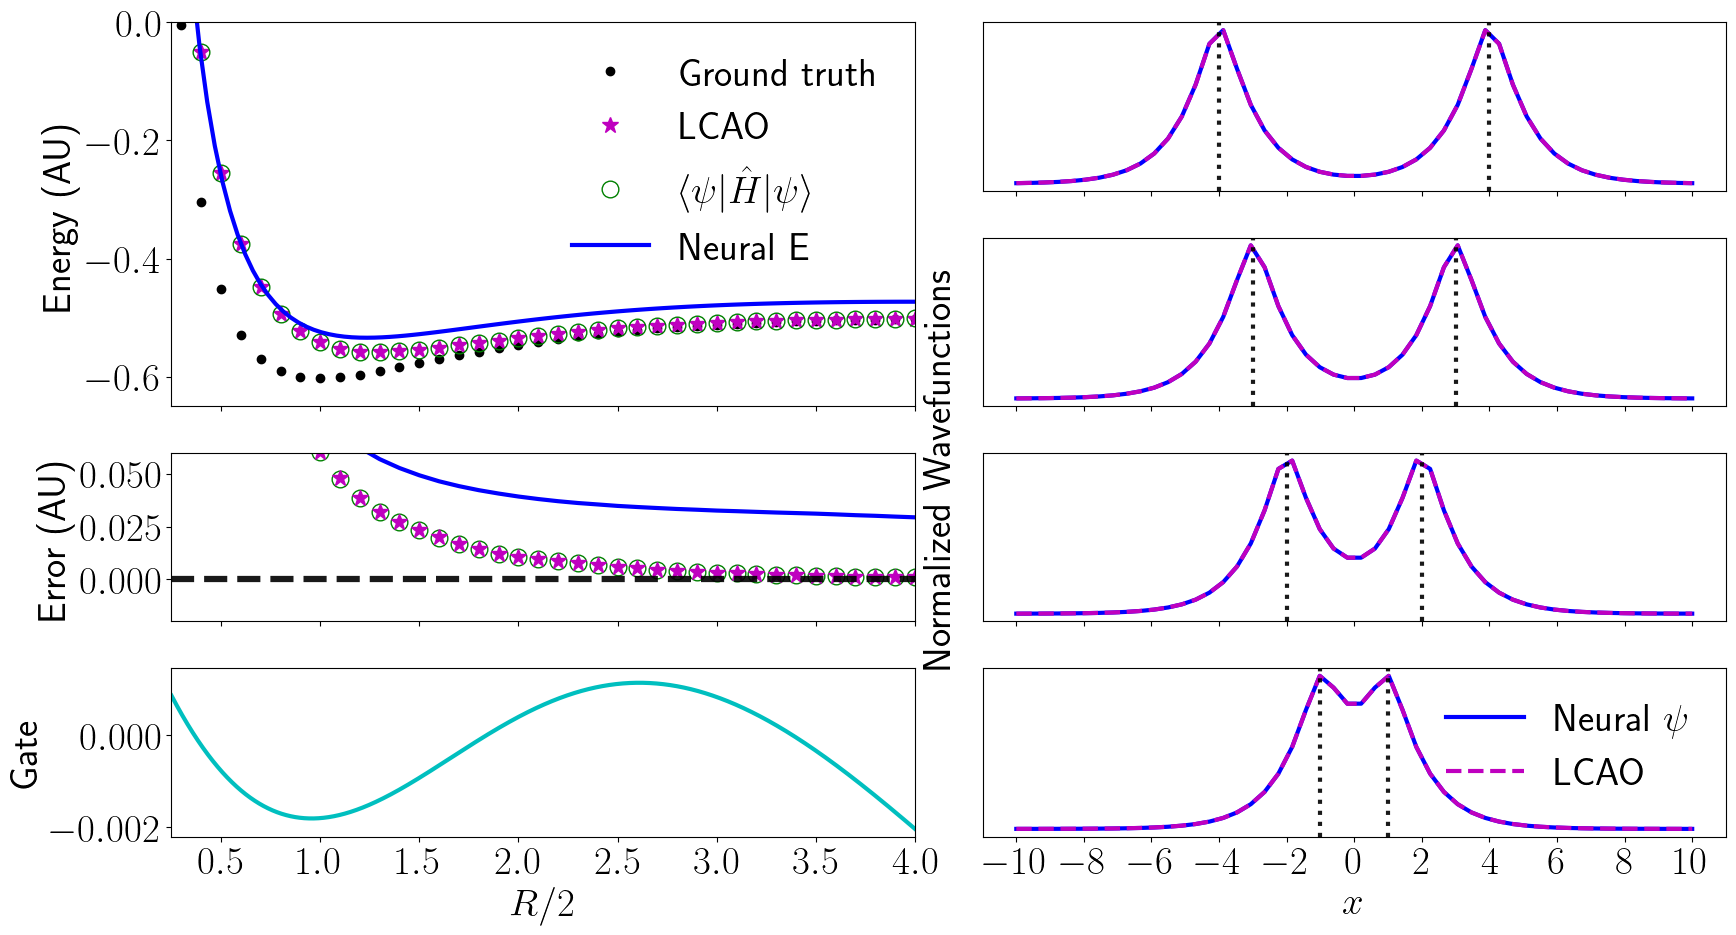

In [24]:
# params['loadModelPath']="models/ionHsym.pt"
params['loadModelPath']="models/ionHsym_fineTune.pt"

modelTest = NN_ion(params);     modelTest.loadModel(params)   


E_int, E_int_lcao, rE, E_net  = load_E_R(params)
Rexact, e_exact = exactE() 


Rtrain_L = params['RxL']; Rtrain_R = params['RxR']; 



xt,yt,zt, Rt1  = sampling(params, params['n_test'], linearSampling=True)
_, Enet_FT = modelTest.parametricPsi(xt, yt, zt, Rt1);
rr = Rt1.cpu().detach().numpy()
ee1 = Enet_FT.cpu().detach().numpy()



### FIGURE 
fig = plt.figure(figsize=(18, 10))


## POTENTIAL ENERGY SURFACE
ax1 = plt.subplot2grid( (4,4), (0,0), colspan=2, rowspan=2); plt.tick_params('x', labelbottom=False)


plt.plot(Rexact, e_exact + 1/2/Rexact, **marker_style_exact, label='Ground truth')
plt.plot(rE, E_int_lcao+1/(2*rE), '*m', label='LCAO',linewidth=lineW)
plt.plot(rE, E_int+1/(2*rE),**marker_style_int, label ='$\langle \psi |\hat H| \psi \\rangle$')
plt.plot(rr, 1/(2*rr) + ee1, **marker_style_net, label='Neural E')
# plt.plot(rr, 1/(2*rr) + ee1, '-b', label='Neural E',linewidth=lineW)
plt.legend(frameon=False)
plt.xlim([0.25,4]); plt.ylim([-0.65, 0]); plt.ylabel('Energy (AU)') # plt.ylabel("$E_{total}$")


# ERROR 
plt.subplot2grid( (4,4), (2,0), colspan=2,  sharex=ax1); plt.tick_params('x', labelbottom=False)
df_net, df_int, df_lcao = E_net-e_exact, E_int-e_exact, E_int_lcao-e_exact
## Compute the Relative error
# df_net = -df_net/e_exact*100; df_int = -df_int/e_exact*100; df_lcao =-df_lcao/e_exact*100

plt.plot(rE,df_int,**marker_style_int)
plt.plot(rE,df_lcao,'*m')
plt.plot(rE,df_net,'b',  **marker_style_net)
plt.ylabel('Error (AU)');  plt.ylim(-0.02,0.06); plt.yticks([0,0.025,0.05])
# plt.ylabel('Relative Error ($\%$)'); plt.ylim(-1,4); plt.yticks([0,2,4])
# plt.legend(frameon=False);
plt.axhline(0, c='k', linestyle='--', linewidth=lineW*1.5, alpha=0.9)


# Gate
plt.subplot2grid( (4,4), (3,0), colspan=2 ,  sharex=ax1)
Rg, gate = returnGate()
axG = plt.plot(Rg, gate, 'c', linewidth=lineW)
plt.ylabel('Gate'); plt.xlabel("$R/2$"); plt.xticks( np.arange(0.5,4.5,0.5))


## WAVEFUNCTIONS
Ri=4
axP = plt.subplot2grid( (4,4), (0,2), colspan=2, rowspan=1)
plt.tick_params('x', labelbottom=False)
plt.plot(x,p4,'b',linewidth=lineW)
plt.plot(x,pL4,'--m',linewidth=lineW)
plt.axvline(-Ri,  c='k', linestyle=':', linewidth=lineW*1, alpha=0.9)
plt.axvline(Ri,  c='k', linestyle=':', linewidth=lineW*1, alpha=0.9)
plt.yticks([])

## 
Ri=3
plt.subplot2grid( (4,4), (1,2), colspan=2, rowspan=1,  sharex=axP)
plt.tick_params('x', labelbottom=False)
plt.plot(x,p3,'b',linewidth=lineW)
plt.plot(x,pL3,'--m',linewidth=lineW)
plt.axvline(-Ri,  c='k', linestyle=':', linewidth=lineW*1, alpha=0.9)
plt.axvline(Ri,  c='k', linestyle=':', linewidth=lineW*1, alpha=0.9)
plt.yticks([])

##
Ri=2
plt.subplot2grid( (4,4), (2,2), colspan=2, rowspan=1,  sharex=axP)
plt.tick_params('x', labelbottom=False)
plt.plot(x,p2,'b',linewidth=lineW)
plt.plot(x,pL2,'--m',linewidth=lineW)
plt.axvline(-Ri,  c='k', linestyle=':', linewidth=lineW*1, alpha=0.9)
plt.axvline(Ri,  c='k', linestyle=':', linewidth=lineW*1, alpha=0.9)
plt.yticks([])

##
Ri=1
plt.subplot2grid( (4,4), (3,2), colspan=2, rowspan=1,  sharex=axP)
plt.plot(x,p1,'b',linewidth=lineW, label='Neural $\psi$')
plt.plot(x,pL1,'--m',linewidth=lineW, label='LCAO')
plt.axvline(-Ri,  c='k', linestyle=':', linewidth=lineW*1, alpha=0.9)
plt.axvline(Ri,  c='k', linestyle=':', linewidth=lineW*1, alpha=0.9)
fig.text(0.54, 0.5, 'Normalized Wavefunctions', ha='center', va='center', rotation='vertical')

plt.legend(frameon=False)
plt.xticks(np.arange(-10,12,2)); plt.xlabel("$x$"); plt.yticks([])
plt.tight_layout()

# plt.savefig('fig3.pdf', format='pdf')



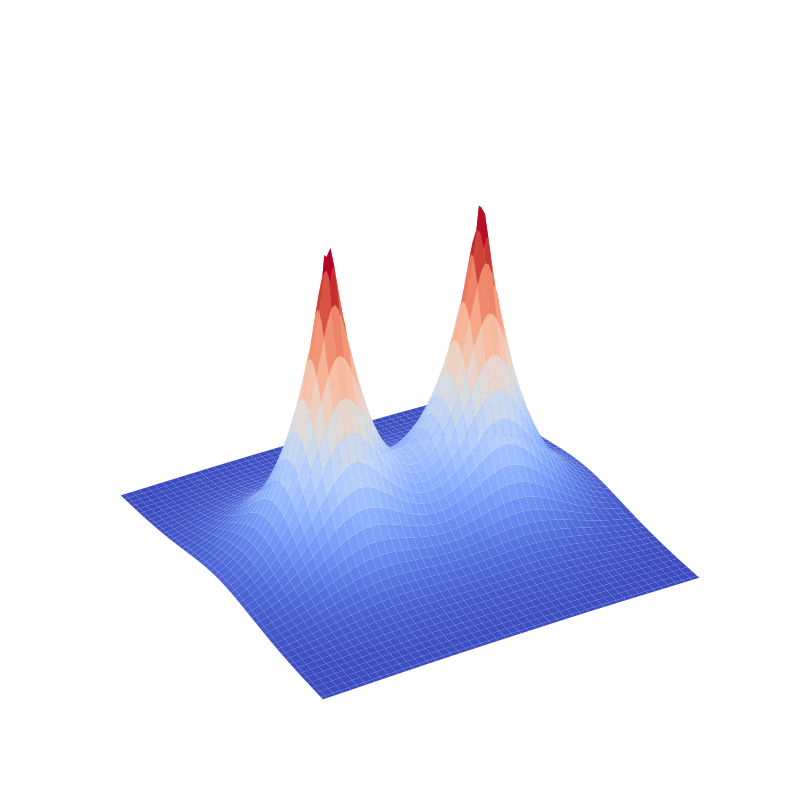

In [25]:
boundaries = 5
params['xL']= -boundaries; params['xR']= boundaries
params['yL']= -boundaries; params['yR']= boundaries
params['zL']= -boundaries; params['zR']= boundaries


params['n_test']= 100#250

Ri=2

x3,y3,z3,psi, psi_L = psi3d(Ri)


cN = int(params['n_test']/2);
xg, yg, zg= np.meshgrid(x3, y3, z3)
gx = xg[:,:,cN]; gy = yg[:,:,cN]; gz = zg[:,cN,:]

ps = (psi[:,:,cN])
ps_L = (psi_L[:,:,cN])



# fig = plt.figure(figsize=(18, 10))
# plt.contourf(gx, gy, ps.T, 100, vmin=ps.min(), vmax=ps.max()  ) 
# plt.tight_layout()


from matplotlib import cm
import pylab
from mpl_toolkits.mplot3d import Axes3D

# fig = pylab.figure(figsize=[10,10]); ax = Axes3D(fig)

fig, ax = plt.subplots(1, subplot_kw={"projection": "3d"}, figsize=[10,10])

ax.plot_surface(gx, gy, ps.T, cmap=cm.coolwarm, antialiased=True, linewidth=0,  
                shade=False, edgecolor='none')

# ax.plot_surface(gx, gy, ps2,  cmap=cm.coolwarm,
#                         linewidth=0, antialiased=False)

plt.xlabel("$x$"); plt.ylabel("$y$")
# ax.set_zlabel("$\psi(x,y,z=0,R=2)$")
ax.set_xticks([]); ax.set_yticks([]); ax.set_zticks([])
ax.view_init(30, 60); ax.grid(True)
ax.axis('off')
#jet

plt.savefig('fig_R2.pdf', format='pdf')



# Derivatives

In [26]:
E_int, E_int_lcao, rE, E_net  = load_E_R(params)
Rexact, e_exact = exactE() 


params['loadModelPath']="models/ionHsym_fineTune.pt"
params['n_test']=40
modelTest = NN_ion(params);    modelTest.loadModel(params)        
x,y,z, R   = sampling(params, params['n_test'], linearSampling=True)
psi_, e_net_an = modelTest.parametricPsi(x,y,z, R);

E_netT_an = e_net_an + 1/(2*R)
E_ex   = e_exact + 1/(2*Rexact)
E_intT = E_int   + 1/(2*rE)
E_netT = E_net   + 1/(2*rE)
E_lcaoT= E_int_lcao+1/(2*rE)

# plt.plot(rE,E_netT)
# plt.plot(R.cpu().detach().numpy(),E_net_an.cpu().detach().numpy(),':')

In [27]:
# AUTO-Diff
F  = -grad([E_netT_an], [R], grad_outputs=torch.ones(R.shape, dtype=dtype), create_graph=True)[0]
F_ = F.cpu().detach().numpy() 

F2 =  grad([F], [R], grad_outputs=torch.ones(R.shape, dtype=dtype), create_graph=True)[0]
F_  = F.cpu().detach().numpy() 
F2_ = F2.cpu().detach().numpy() 


## FINITE DIFFERENCES 
F_ex = np.zeros(len(Rexact)-1)
F_int = np.zeros(len(rE)-1)
F_net = np.zeros(len(rE)-1)
F_lcao= np.zeros(len(rE)-1)
i=0
for i in range(len(Rexact)-1):
    F_ex[i]  = -(E_ex[i+1]-E_ex[i])/(Rexact[i+1]-Rexact[i])
    F_int[i] = -(E_intT[i+1]-E_intT[i])/(rE[i+1]-rE[i])
    F_net[i] = -(E_netT[i+1]-E_netT[i])/(rE[i+1]-rE[i])
    F_lcao[i]= -(E_lcaoT[i+1]-E_lcaoT[i])/(rE[i+1]-rE[i])
    i += 1
    print


    
## EQUALY
# dE =  grad([e_net_an], [R], grad_outputs=torch.ones(R.shape, dtype=dtype), create_graph=True)[0]
# dE2 =  grad([dE], [R], grad_outputs=torch.ones(R.shape, dtype=dtype), create_graph=True)[0]

# dE  = dE  - 1/(2*R.pow(2))
# dE2 = dE + 1/(R.pow(3))

# dE_  = dE.cpu().detach().numpy() 
# dE2_ = dE2.cpu().detach().numpy() 

# plt.plot(R.cpu().detach().numpy(), dE_)
# plt.plot(R.cpu().detach().numpy(), dE2_)

# Derivative (Force)

# Figure 4

In [28]:
params['loadModelPath']="models/ionHsym_fineTune.pt"

modelTest = NN_ion(params);     modelTest.loadModel(params)   


E_int, E_int_lcao, rE, E_net  = load_E_R(params)
Rexact, e_exact = exactE() 


Rtrain_L = params['RxL']; Rtrain_R = params['RxR']; 


xt,yt,zt, Rt1  = sampling(params, params['n_test'], linearSampling=True)
_, Enet_FT = modelTest.parametricPsi(xt, yt, zt, Rt1);
rr = Rt1.cpu().detach().numpy()
ee1 = Enet_FT.cpu().detach().numpy()



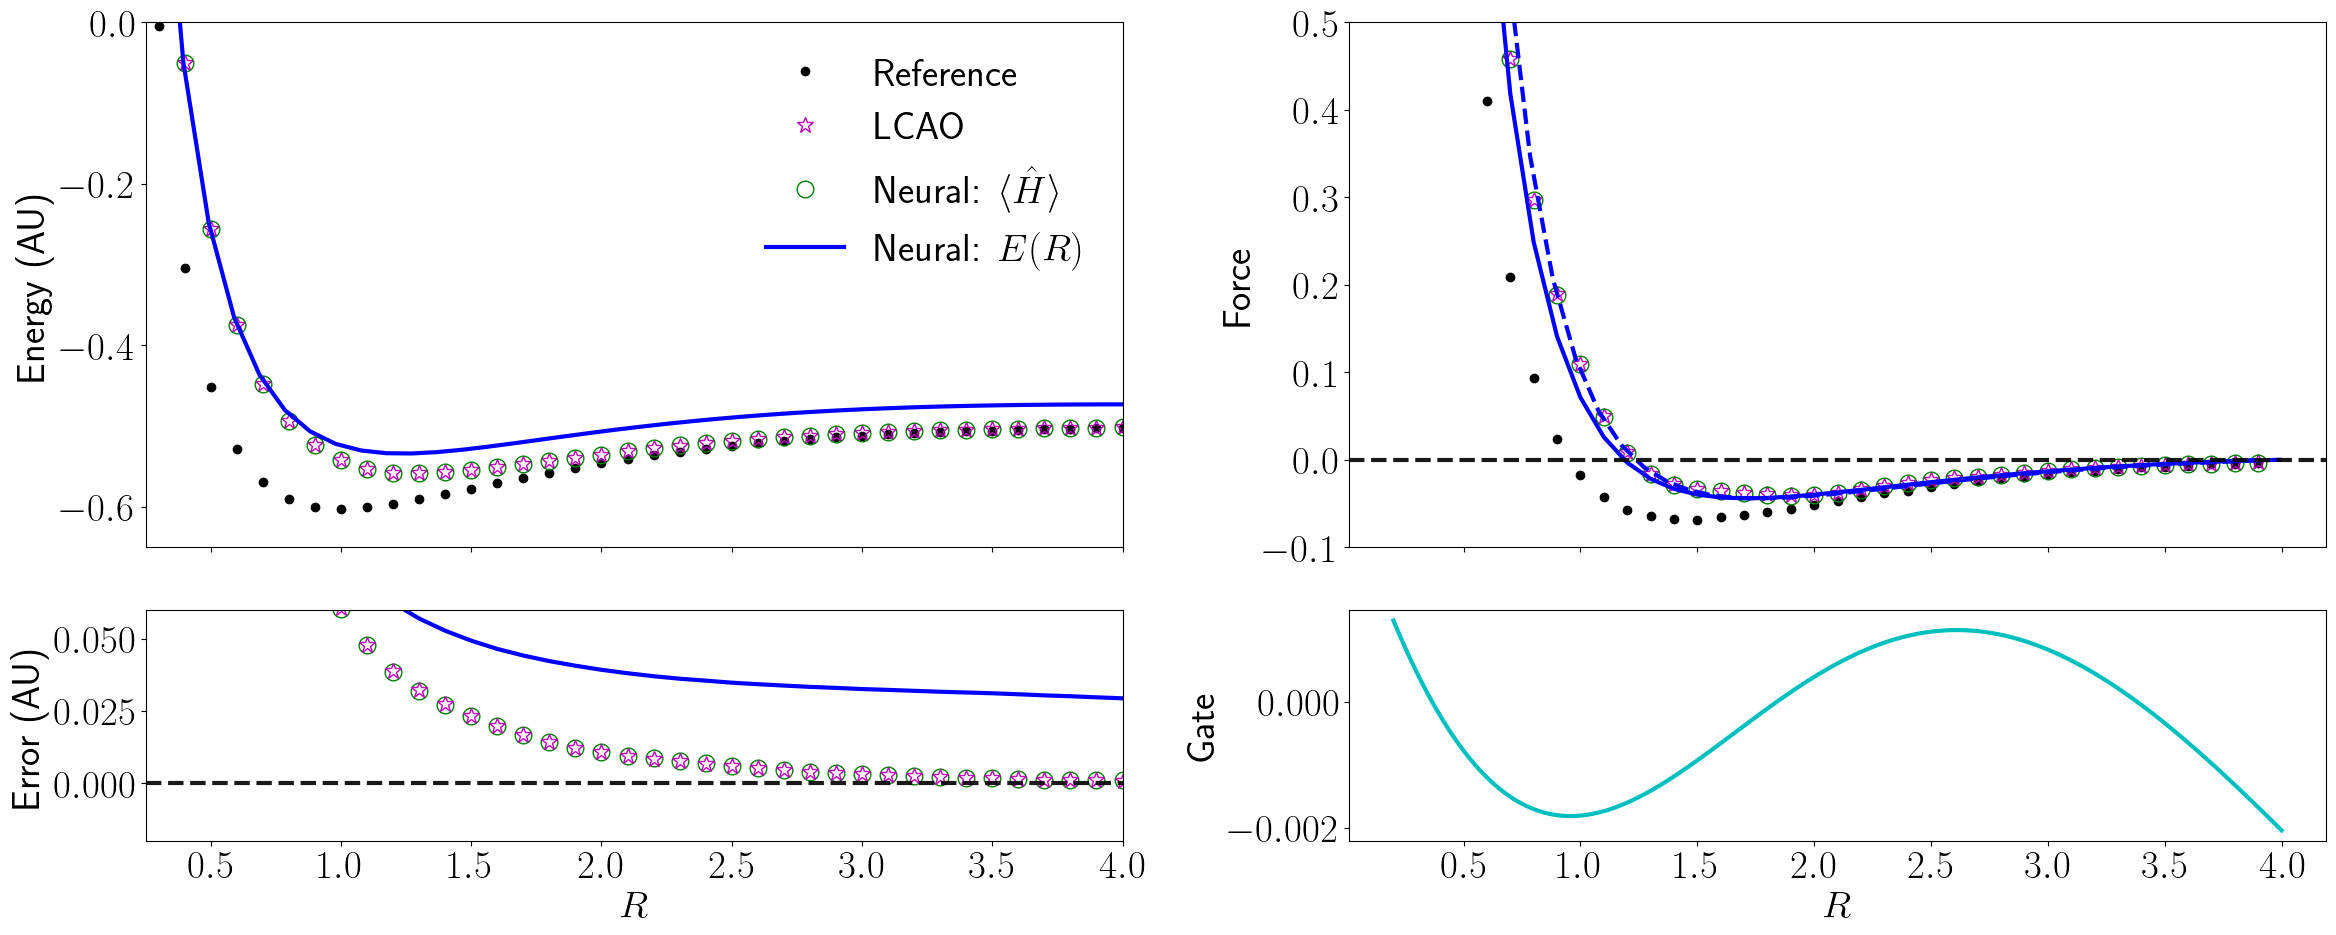

In [29]:
### FIGURE
marker_style_exact = dict(color='k', linestyle='none', marker='.', 
                      fillstyle='full',linewidth=lineW)

marker_style_int = dict(color='g', linestyle='none', marker='o', 
                      fillstyle='none', linewidth=lineW)

marker_style_net = dict(color='b', linestyle='-',linewidth=lineW)

marker_style_lcao = dict(color='m', linestyle='none', marker='*', 
                      fillstyle='none', linewidth=lineW)


fig = plt.figure(figsize=(24, 10))


## POTENTIAL ENERGY SURFACE
ax1 = plt.subplot2grid( (3,2), (0,0), colspan=1, rowspan=2); plt.tick_params('x', labelbottom=False)

plt.plot(Rexact, e_exact + 1/2/Rexact, **marker_style_exact, label='Reference')#: $E_{t}$' )
plt.plot(rE, E_int_lcao+1/(2*rE), **marker_style_lcao, label='LCAO')#: $\langle E_\ell \\rangle$')
plt.plot(rE, E_int+1/(2*rE),**marker_style_int, label ='Neural: $\langle \hat H \\rangle$'); 
plt.plot(rr, 1/(2*rr) + ee1, **marker_style_net, label='Neural: $E(R)$');
# plt.plot(rr, 1/(2*rr) + ee1, '-b', label='Neural E',linewidth=lineW)
plt.legend(frameon=False)
plt.xlim([0.25,4]); plt.ylim([-0.65, 0]); plt.ylabel('Energy (AU)') # plt.ylabel("$E_{total}$")



# ERROR 
plt.subplot2grid( (3,2), (2,0), colspan=1,  sharex=ax1); plt.tick_params('x', labelbottom=True)
df_net, df_int, df_lcao = E_net-e_exact, E_int-e_exact, E_int_lcao-e_exact

plt.plot(rE,df_int,**marker_style_int);
plt.plot(rE,df_lcao,**marker_style_lcao);
plt.plot(rE,df_net,'b',  **marker_style_net);
plt.ylabel('Error (AU)');  plt.ylim(-0.02,0.06); plt.yticks([0,0.025,0.05])
plt.axhline(0, c='k', linestyle='--', linewidth=lineW*1., alpha=0.9)
plt.xlabel("$R$"); plt.xticks( np.arange(0.5,4.5,0.5))




# label='LCAO: $\langle E_\ell \\rangle$'
# label ='Neural: $\langle E \\rangle$'
# label='Neural: $E$'

## Force field SURFACE
ax1 = plt.subplot2grid( (3,2), (0,1), colspan=2, rowspan=2); plt.tick_params('x', labelbottom=False)

# -\frac{\partial E_{t}}{\partial R
plt.plot(Rexact[0:-1],F_ex, **marker_style_exact, label='$-{\partial E_{t}}/{\partial R}$ (Finite Diff.)')
plt.plot(rE[0:-1],F_lcao,  **marker_style_lcao, label='$-{\langle\partial E_{\ell}\\rangle}/{\partial R}$ (Finite Diff.)')
plt.plot(rE[0:-1], F_int , **marker_style_int, label='$-{\partial \langle E \\rangle}/{\partial R}$ (Finite diff.)')
plt.plot(rE[0:-1],F_net, **marker_style_net,label='$-{\partial E}/{\partial R}$ (Finite Diff.)')
plt.plot(R.cpu().detach().numpy(), F_, '--b',linewidth=lineW,label='$-{\partial E}/{\partial R}$ (autograd)')

plt.ylabel('Force')
# plt.legend(frameon=False)
plt.ylim([-.1,0.5])


# plt.legend()


plt.axhline(0, c='k', linestyle='--', linewidth=lineW*1, alpha=0.9)



# Gate
plt.subplot2grid( (3,2), (2,1), colspan=1 ,  sharex=ax1)
Rg, gate = returnGate()
axG = plt.plot(Rg, gate, 'c', linewidth=lineW);
plt.ylabel('Gate'); plt.xlabel("$R$"); plt.xticks( np.arange(0.5,4.5,0.5))

plt.tight_layout()

plt.savefig('fig4.pdf', format='pdf')




# Hellmann-Feynman theorem

In [30]:
def hamiltonian_R(x,y,z,R,psi,params):
    r1,r2 = radial(x,y,z,R, params)
    # V = -1/r1 -1/r2
    # VR = grad([V], [R], grad_outputs=torch.ones(R.shape, dtype=dtype), create_graph=True)[0]    
    VR = -(x-R)/r1.pow(3) + (x+R)/r2.pow(3)    
    return VR*psi

def dEdR_int(Ri,params):
    modelTest = NN_ion(params);    modelTest.loadModel(params)        
    x,y,z, R   = sampling(params, params['n_test'], linearSampling=True)
    x=x.ravel(); y=y.ravel(); z=z.ravel() 

    xg, yg, zg= torch.meshgrid(x, y, z)
    xgg = xg.reshape(-1,1); ygg = yg.reshape(-1,1); zgg = zg.reshape(-1,1)

    Rt = Ri*torch.ones_like(xgg)
    # Rt.requires_grad=True
    
    psi_, E = modelTest.parametricPsi(xgg, ygg, zgg, Rt);
    psi = psi_.reshape(params['n_test'],params['n_test'],params['n_test'])    
 

    Npsi   = 1/np.sqrt(integra3d(x.cpu(),y.cpu(),z.cpu(), (psi.cpu()).pow(2)))
    psi=Npsi*psi
    psi_=Npsi*psi_

    
    hR_psi = hamiltonian_R(xgg,ygg,zgg, Rt, psi_, params)
    
    x=x.cpu(); y=y.cpu(); z=z.cpu();     psi=psi.cpu();     hR_psi=hR_psi.cpu(); 
    hR_psi = hR_psi.reshape(params['n_test'],params['n_test'],params['n_test'])
    dE_integral = integra3d(x,y,z, psi * hR_psi)

    dE_integral = dE_integral - 1/(2*Ri**2) 
    return dE_integral

In [32]:
## FOR 250 test points you need more than 32GB     

params['n_test']= 100
Ri = 1

torch.cuda.empty_cache()
dE_HF = dEdR_int(Ri,params)
dE_HF

-0.22222897390350232

In [33]:
Rx_list_net = np.round(np.arange(params['RxL'], params['RxR']+.1, .1),2)  

i=0
dE_HF = np.zeros(len(Rx_list_net)); rE = np.zeros(len(Rx_list_net))

for Ri in Rx_list_net:   
    torch.cuda.empty_cache()
    dE_HF[i] = dEdR_int(Ri,params)
    rE[i]=Ri
    i = i+1


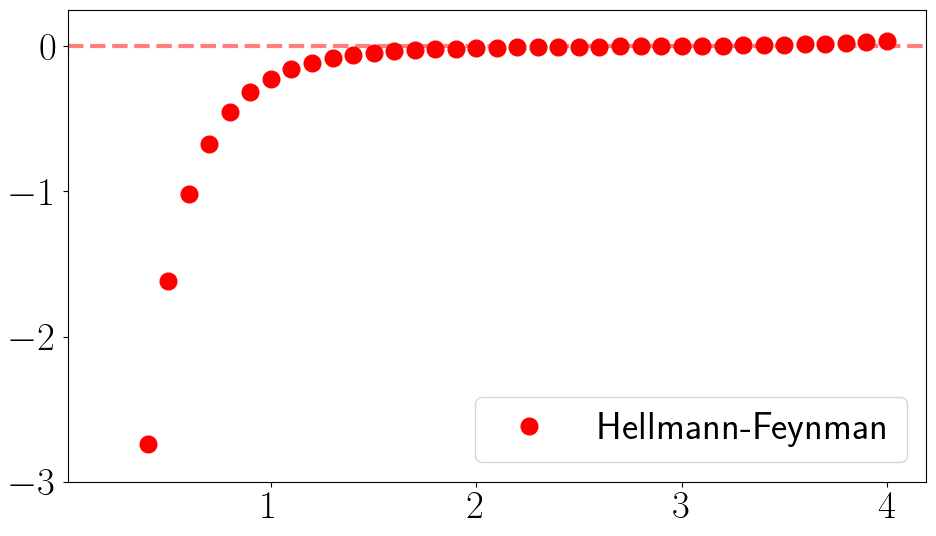

In [34]:
plt.figure(figsize=(10,6))
#plt.plot(R.cpu().detach().numpy(), dE_, '--b',linewidth=lineW,label='Using auto-diff')
#plt.plot(rE[0:-1], dE_int , **marker_style_int, label='From Expectation')
#plt.plot(Rexact[0:-1],dE_ex, **marker_style_exact)
#plt.plot(rE[0:-1],dE_net, **marker_style_net,label='finite difference')
plt.plot(rE,dE_HF,'or', label='Hellmann-Feynman')
plt.axhline(0, c='r', linestyle='--', linewidth=lineW*1, alpha=0.5)


plt.legend()


plt.ylim([-3,0.25])
plt.tight_layout()




In [35]:
# vv = V(xgg, ygg, zgg, Rt, params)
# Rt.requires_grad
# grad([vv], [Rt], grad_outputs=torch.ones(Rt.shape, dtype=dtype), create_graph=True)[0]

NameError: name 'R_' is not defined

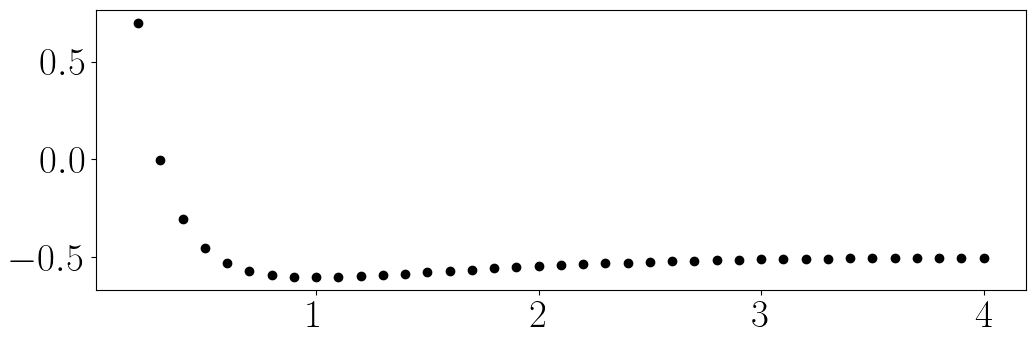

In [38]:
marker_style_exact = dict(color='k', linestyle='none', marker='.', 
                      fillstyle='full',linewidth=lineW)

marker_style_int = dict(color='g', linestyle='none', marker='o', 
                      fillstyle='none', linewidth=lineW)

plt.figure(figsize=[12,8])

# ax1 = plt.subplot2grid( (2,2), (2,0), colspan=2,  sharex=ax1); plt.tick_params('x', labelbottom=False)

plt.subplot(2,1,1)

plt.plot(Rexact, e_exact + 1/2/Rexact, **marker_style_exact, label='Ground truth')
plt.plot(R_, E_ ,'b', linewidth=lineW, label='NN output')
plt.plot(rE, E_int+1/(2*rE),**marker_style_int, label='Hellmann-Feynman')
plt.legend()
plt.ylim([-.65,-0.2])

# plt.figure(figsize=[6,4])
plt.subplot(2,1,2)


plt.plot(R_, dE_, 'b')
plt.plot(rE, dE_int ,  **marker_style_int)
plt.plot(rE[0:-1],dE_ex, **marker_style_exact)
plt.axhline(0, c='r', linestyle='--', linewidth=lineW*1, alpha=0.5)


# plt.plot(R_, dE2_, 'g')
plt.ylim([-2,0.25])

In [20]:
len(Rexact)

39

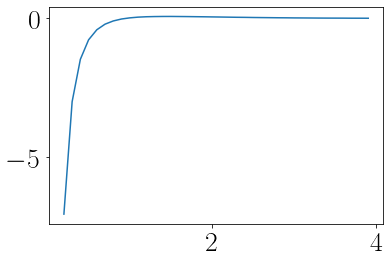

# END

In [40]:

def energy_from_psi(params, printE=False, calcLCAO=False):

    max_d=7
    params['xL']= -max_d; params['xR']= max_d; 
    params['zL']= -max_d; params['zR']=  max_d; 
    params['yL']= -max_d; params['yR']= max_d; 

    modelTest = NN_ion(params);    modelTest.loadModel(params)        
    
    x,y,z, _ = sampling(params, params['n_test'], linearSampling=True)
    x=x.ravel(); y=y.ravel(); z=z.ravel() 
    xg, yg, zg= torch.meshgrid(x, y, z)
    xgg = xg.reshape(-1,1); ygg = yg.reshape(-1,1); zgg = zg.reshape(-1,1)
    
    psi_, E = modelTest.parametricPsi(xgg, ygg, zgg);
    psi = psi_.reshape(params['n_test'],params['n_test'],params['n_test'])
       
    # # Energy from psi    
    h_psi = hamiltonian(xgg,ygg,zgg, psi_, params)
    h_psi = h_psi.reshape(params['n_test'],params['n_test'],params['n_test'])
    E_integral = integra3d(x,y,z, psi * h_psi) / integra3d(x,y,z, (psi).pow(2))
    Eparameter = E[-1].detach().numpy()

    #############
    ## LCAO 
    #############
    E_integral_lcao = 0
    if calcLCAO==True:
        fi_r1, fi_r2 = modelTest.atomicUnit( (xgg), ygg, zgg)  
        psi_L_  = modelTest.lcao_solution(fi_r1, fi_r2 )    
        psi_L = psi_L_.reshape(params['n_test'],params['n_test'],params['n_test'])
        h_psi_L = hamiltonian(xgg,ygg,zgg,psi_L_,params)
        h_psi_L = h_psi_L.reshape(params['n_test'],params['n_test'],params['n_test'])        
        E_integral_lcao = integra3d(x,y,z, psi_L*h_psi_L)/integra3d(x,y,z, psi_L.pow(2))
    
    if printE==True:
        print('E_integral = ',  E_integral); print('E_param = ', Eparameter); 
        print('E_exac = ',  -1.452)
        print('E_lcao_daniel = ', -1.288); 
        print('E_integral_LCAO = ' ,  E_integral_lcao)
        
    return E_integral, Eparameter, E_integral_lcao

def plot_psi(params, plotSurf=False, saveFig=False):
   
    modelTest = NN_ion(params);    modelTest.loadModel(params)          
    
    x,y,z  = sampling(params, params['n_test'], linearSampling=True)
    x=x.ravel(); y=y.ravel(); z=z.ravel() 
    xg, yg, zg= torch.meshgrid(x, y, z)
    xgg = xg.reshape(-1,1); ygg = yg.reshape(-1,1); zgg = zg.reshape(-1,1)
        
    psi_, E = modelTest.parametricPsi(xgg, ygg, zgg);
    psi = psi_.reshape(params['n_test'],params['n_test'],params['n_test'])    
    
    psi = psi.cpu()
    xgg=xgg.cpu()
    ygg=ygg.cpu()
    zgg=zgg.cpu()
    xg=xg.cpu()
    yg=yg.cpu()
    zg=zg.cpu()
    x=x.cpu()
    y=y.cpu()
    z=z.cpu()

    
    
    psi=psi/np.sqrt(integra3d(x,y,z, (psi).pow(2))); # print('Normalization of psi')


    # LCAO
    fi_r1, fi_r2 = modelTest.atomicUnit( (xgg), ygg, zgg)  
    psi_L_  = modelTest.lcao_solution(fi_r1, fi_r2 )
    # r1,r2 = radial(xgg, ygg, zgg,params)
    # psi_L_ = torch.exp(-r1) + torch.exp(-r2)    
    psi_L = psi_L_.reshape(params['n_test'],params['n_test'],params['n_test'])
    psi_L = psi_L/np.sqrt(integra3d(x,y,z, (psi_L).pow(2))); # print('Normalization of psi LCAO')

    cN = int(params['n_test']/2); # print('z_cut = ', zg[0,0,cN], 'y_cut = ', yg[0,cN,0])
    gx = xg[:,:,cN].detach().numpy(); gy = yg[:,:,cN].detach().numpy(); #gz = zg[:,cN,:].detach().numpy()
    
    ps2 = (psi[:,:,cN])
    psiCut = ps2[:,cN].reshape(-1,1)
    
    ps2_L = (psi_L[:,:,cN])
    ps2_LCut = (ps2_L[:,cN]).reshape(-1,1)
    
    
    # res = hamiltonian(x,y,z, psiCut.squeeze(), params) - E[-1]*psiCut.squeeze()
    # res_L = hamiltonian(x,y,z, ps2_LCut.squeeze(), params) + 1.288*ps2_LCut.squeeze()
    
    ps2=ps2.detach().numpy()
    psiCut=psiCut.pow(2).detach().numpy()
   
    ps2_L    = ps2_L.detach().numpy()
    ps2_LCut = ps2_LCut.pow(2).detach().numpy()
       
    
    fig,ax = plt.subplots(3, sharex=True, figsize=[8,12]) 
    
    ax[0].contourf(gx, gy, ps2, 100, vmin=ps2.min(), vmax=ps2.max()  ) 
    ax[0].set_ylabel('$y$')
    # ax[0].set_xlabel('$x$')
    ax[1].plot(x.detach().numpy(), psiCut,'b',label='NN')
    ax[1].plot(x.detach().numpy(), ps2_LCut,'r',label='LCAO')
    ax[1].set_xlabel('$x$')
    ax[1].legend()
    ax[2].plot(x.detach().numpy(), psiCut-ps2_LCut,'k')
    ax[2].set_xlabel('$x$'); ax[2].set_ylabel('$NN-LCAO$')
    # ax[3].plot(x.detach().numpy(), res.detach().numpy(),'b',label='NN')
    # ax[3].plot(x.detach().numpy(), res_L.detach().numpy(),'r',label='LCAO')
    # ax[3].set_xlabel('$x$'); ax[3].set_ylabel('$Residuals$')
    fig.tight_layout()
    if saveFig == True:
        fig.savefig('figures/solution_figure.jpg', format='jpg')


    fig.tight_layout()

    if plotSurf==True:
        from matplotlib import cm
        fig, ax = plt.subplots(1, subplot_kw={"projection": "3d"})
        
        ax.plot_surface(gx, gy, ps2,  cmap=cm.coolwarm,
                                linewidth=0, antialiased=True)
        
        fig, ax = plt.subplots(1, subplot_kw={"projection": "3d"})
        ax.plot_surface(gx, gy, ps2_L,  cmap=cm.coolwarm,
                                linewidth=0, antialiased=True)
        if saveFig == True:
            fig.savefig('figures/surfacePlot_figure.jpg', format='jpg')


def trainMultipleModels(params, Rx_list):
    print('TRAIN MANY MODELS')    
    for r in Rx_list:
        print('\n R = ', 2*r)
        params['Rx'] = r
        params['lossPath'] = "data/loss_ionH" + '_R=' + str( round(2*r, 1)) + '.pkl' ; 
        params['saveModelPath']="models/ionH" + '_R=' + str( round(2*r, 1)) +".pt"
        params['loadModelPath']="models/ionH" + '_R=' + str( round(2*r, 1)) +".pt"
        train(params, loadWeights=False);  


def evaluateMultipleModels(params, Rx_list, plots=False, saveEnergies=False):
    # params['xL']= -5; params['xR']=  5; 
    params['yL']= -0; params['yR']=  0; 
    params['zL']= -0; params['zR']=  0;     
    x,y,z  = sampling(params, params['n_test'], linearSampling=True)
       
    
    e_exact  = np.zeros([len(Rx_list),1])
## R ->    [0.4 : 0.1 : 4.0 ]
    e_exact = [-1.8, -1.67, -1.55, 
               -1.45, -1.36, -1.28, -1.22, -1.156,
               -1.10, -1.06, -1.01,  -0.98, -0.94,
               -0.91, -0.88, -0.86, -0.84, -0.81,
               -0.80]

    e_all = np.zeros([len(Rx_list),1])
    Etot = np.zeros([len(Rx_list),1])
    Etot_exact = np.zeros([len(Rx_list),1])
    
    E_int = np.zeros([len(Rx_list),1])
    E_int_L = np.zeros([len(Rx_list),1])
        
    j=0
    for r in Rx_list:
        params['Rx'] = r
        params['lossPath']="data/loss_ionH" + '_R=' + str( round(2*r, 1)) + '.pkl' 
        params['saveModelPath']="models/ionH" + '_R=' + str( round(2*r, 1)) +".pt"
        params['loadModelPath']="models/ionH" + '_R=' + str( round(2*r, 1)) +".pt"
    
        modelTest = NN_ion(params)
        modelTest.loadModel(params)    
        psi, E = modelTest.parametricPsi(x,y,z)

        
        e_all[j]= E[-1].detach().numpy()
        # print('Interatomic distance: ', 2*params['Rx'])
    
        Etot[j] = E[-1].detach().numpy() + 1/(2*r)
        Etot_exact[j] =e_exact[j] + 1/(2*r)
        
        
        if plots==True:
            plot_psi(params, plotSurf=False); plt.title('r = ' + str(r))
            plotLoss(params, saveFig=False); plt.title('r = ' + str(r))

        E_int[j], Eparameter, E_int_L[j] = energy_from_psi(params, printE = False, calcLCAO=False)
        
        E_int[j]   = E_int[j]    + 1/(2*r)
        E_int_L[j] = E_int_L[j]  + 1/(2*r)
        
        j+=1
        
    if saveEnergies==True:
        EnergyDictionary = {'Etot': Etot, 'e_all': e_all,'Etot_exact': Etot_exact,'E_int':  E_int, 'E_int_L':  E_int_L}
        with open(params['EnergyPath'], 'wb') as f:
            pickle.dump(EnergyDictionary, f)
    # return Etot, e_all, Etot_exact, E_int, E_int_L



def plot_EforR(params,Rx_list,  plotIntegral=False):

    with open(params['EnergyPath'], 'rb') as f:
        enr_dic = pickle.load(f)

    Etot,  Etot_exact = enr_dic['Etot'],  enr_dic['Etot_exact']
    E_int, E_int_L  = enr_dic['E_int'],enr_dic['E_int_L']
    # e_all =enr_dic['e_all'],

    
    e_lcao, Etot_lcao, R_lcao = LCAO_dispersion()
    
    plt.figure(figsize=[12,8])    
    plt.plot(Rx_list, Etot,'o-b', label='Network')

    plt.plot(Rx_list, Etot_exact,'^-k', label='Exact')
    plt.plot(R_lcao ,Etot_lcao,'*-m',label='LCAO', alpha=0.7)

    if plotIntegral==True:
        plt.plot(Rx_list, E_int,'x-g', label='network_integral')
        # plt.plot(Rx_list ,E_int_L,'*-r',label='LCAO integral', alpha=0.7)

    plt.legend()
    
    # plt.xlim([0.9*min(Rx_list),1.1*max(Rx_list)])
    plt.xlim([0,2])

    plt.ylim([-1,1])

    plt.xlabel('Half interatomic distance')    
    plt.ylabel('Energy')   
    plt.tight_layout()
    
    # plt.ylim([-2.5,-0.5])

    plt.savefig('figures/dispersion.jpg', format='jpg')
        

In [41]:
plot_psi(params, plotSurf=False)

ValueError: too many values to unpack (expected 3)